## Imports

In [94]:
import pandas as pd
import requests
import json
import re
import sys
import numpy as np
import os
import nltk
import pickle
import glob
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.utils import shuffle
from importlib import reload
from dateutil.parser import parse
from time import time
import pycountry

In [2]:
# from sklearn import naive_bayes
from sklearn import pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sentence_transformers import SentenceTransformer

ModuleNotFoundError: No module named 'sentence_transformers'

## Data

### Data load

#### Read pdf texts

In [18]:
def read_data_frm_pkl(folder):
    pkl_df = pd.DataFrame(columns=['doc_name', 'content'])
    reviewd_files = os.listdir(folder)
    for file_name in reviewd_files:
        if not '.pkl' in file_name:
            continue
        
        file_path = os.path.join(folder, file_name)

        with open(file_path, 'rb') as f:
            text_arr = pickle.load(f)
            text = ' '.join(text_arr[1:5])  + ' '.join(text_arr[-4:])

        pkl_df = pkl_df.append(
                        {'doc_name': file_name,
                        'content': text,
                        'full_content': text_arr}, ignore_index=True)
    return pkl_df

In [19]:
FIRST_SET_FOLDER = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\1st doc subset_ PSE EGM Documents (without BHA)"
df_first = read_data_frm_pkl(FIRST_SET_FOLDER)

In [20]:
SECOND_SET_FOLDER = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\2nd doc subset_ PSE EGM BHA Documents"
df_second =  read_data_frm_pkl(SECOND_SET_FOLDER)

In [23]:
df = pd.concat([df_first, df_second])

In [21]:
df_second.shape

(186, 3)

In [24]:
df.shape

(772, 3)

#### Read metadata

In [45]:
big_table_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\Categorization Matrix-Grid view Full.csv"
big_metadata_df = pd.read_csv(big_table_path)

In [46]:
small_table_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\Categorization Matrix-Grid view Second.csv"
small_metadata_df = pd.read_csv(small_table_path)

In [72]:
metadata_df = pd.concat([big_metadata_df, small_metadata_df])
metadata_df.shape

(879, 25)

### Data Merge

In [48]:
df.head(2)

,doc_name,content,full_content,Document ID
0,0000-APLU-PAK.pkl,\n \n \n \n\nAcknowledgements \n\nMany people...,[ \n\n \n\n \n\n \n\nFeasibility Study of th...,0000-aplu-pak
1,0000-Chile-ZMB.pkl,\n\n \n\n \n\n \n\n \n\nRepublic of Zambia \n...,[ \n\n \n \n\n \n\n \n\n \n\nRepublic of Zambi...,0000-chile-zmb


In [73]:
len(set(metadata_df['Document ID'].values))

784

In [49]:
metadata_df.head(2)

,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,Technical Sector,Special Considerations,Private Sector Industry,Type of Enterprise,...,PSE Key Values,PSE Key Values USAID Offers,Key Findings,Key Recommendations,Document Attachment,Google Drive Link,Internet URL of Document,Reviewer Name,Review Complete?,Review Stage
0,0000-APLU-PAK,Feasibility Study of the US-Pakistan Knowledge...,Association for Public and Land-grant Universi...,NaN,USAID,NaN,Education and Social Services,Youth,Educational Services,NaN,...,"""Scale, Sustainability, and Reach"",""Innovation...","Sectoral Expertise and Knowledge,Support to St...",We can learn from past individual training pro...,Recommendations for aligning program goals:\n1...,0000-APLU-PAK.pdf (https://dl.airtable.com/.at...,https://drive.google.com/open?id=1foT7HO75eCJ-...,https://pdf.usaid.gov/pdf_docs/PA00N7DN.pdf,"Mehak,Anna",checked,Second Review
1,0000-Chile-ZMB,Teacher Effectiveness. Towards Sustainable Del...,"John Chileshe,Geoffrey Tambulukani",NaN,USAID,NaN,Education and Social Services,NaN,NaN,NaN,...,Efficiency and Effectiveness,Sectoral Expertise and Knowledge,"According to this article, the head teacher is...",The following are examples of key best practic...,0000-Chile-ZMB.pdf (https://dl.airtable.com/.a...,https://drive.google.com/open?id=1dzE6kGKQRTK-...,https://pdf.usaid.gov/pdf_docs/PA00MWT9.pdf,"Mehak,Lauren",checked,Second Review


In [81]:
df.shape

(772, 4)

In [69]:
metadata_df.shape

(784, 25)

In [80]:
df['Document ID'] = df['doc_name'].str.split('.').str[0].str.lower().str.strip().str.replace('-pr', "")

metadata_df = metadata_df.drop_duplicates(subset=['Document ID'])
metadata_df['Document ID'] = metadata_df['Document ID'].str.lower().str.strip().str.replace('-pr', "")

df_text = pd.merge(df, metadata_df,
                  how='inner',
                  on='Document ID')

C:\Users\Volha_Skidan\Anaconda3\envs\havos\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [82]:
df_text.shape

(726, 28)

In [83]:
len(set(metadata_df['Document ID'].values))

779

In [84]:
len(set(df['Document ID'].values))

772

### Text processing

In [85]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\se]', '', str(text).lower().strip())
    text = text.replace('\n',"").replace('\t',"")
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    
    #remove shorts
    lst_text = [word for word in lst_text if len(word) > 2]
        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)

    return text

lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords[:2]

['i', 'me']

In [86]:
df_text["text_clean"] = df_text["content"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

## Information Extraction

In [30]:
title_author_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\Titles, authors and publishers (2nd doc subset).csv"
title_author_df = pd.read_csv(title_author_path, sep=';')
title_author_df.head(2)

,Unnamed: 0,document_name,title_found,authors_organizations,authors_institutions,publishing_institutions
0,0,0000-BOMM-COD.pdf,Changing aid industry norms applying the marke...,set(),"{'Marco Venier', 'Diane Bommart', 'Kim Beevers'}",set()
1,1,0000-BOURI-GLO.pdf,Unleashing private capital for global health i...,{'USAID'},{'Amit Bouri'},{'USAID'}


In [73]:
title_author_df['document_name'] = title_author_df['document_name'].str.split('.').str[0]
df_small_text['document_name'] = df_small_text['doc_name'].str.split('.').str[0]

In [74]:
df_small_text = pd.merge(df_small_text, title_author_df,
                 on = 'document_name')

In [75]:
df_small_text.shape

(160, 35)

### Title extraction

### Author extraction - not yet

### Year extraction

In [89]:
def extract_first_4digits(s):
    if s is None:
        return None
    text = ' '.join(s[:3])
    possible_years = re.findall(r"[^\d]\d\d\d\d[^\d]", text)
    for year in possible_years:
        year = re.findall(r'\d+', year)[0]
        if int(year) < 2022 and int(year) > 1980:
            return float(year)
    return None

df_text['found_year'] = df_text['full_content'].apply(extract_first_4digits)
df_text['Year'] = df_text['Year'].astype('float')

In [91]:
print("Matched years: ", df_text[(df_text['Year'].notna()) & (abs(df_text['Year'] - df_text['found_year'])) < 0.1].shape[0])
print("Non-empty years: ", df_text[df_text['Year'].notna()].shape[0])
print("Correct part: ", df_text[(df_text['Year'].notna()) & (abs(df_text['Year'] - df_text['found_year'])) < 0.1].shape[0] / df_text[df_text['Year'].notna()].shape[0])

Matched years:  569
Non-empty years:  696
Correct part:  0.8175287356321839


In [92]:
df_text[['doc_name', 'Year', 'found_year']].iloc[20:25]

,doc_name,Year,found_year
20,0000-USAID-UGA-C.pkl,NaN,2018.0
21,0400-Diara-MLT-pr.pkl,2004.0,2004.0
22,0402-Newel-NPL-pr.pkl,2004.0,NaN
23,0408-Bull-GLO-pr.pkl,2004.0,NaN
24,0701-Ochie-MLT-pr.pkl,2007.0,2007.0


### Private Sector Partners - Search from list - Need additional development

In [24]:
priv_sect_partners_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\Private Sector Partners-Grid view.csv"
priv_sect_partners_df = pd.read_csv(priv_sect_partners_path)
priv_sect_partners_df.head(5)
priv_sect_partners_list = list(priv_sect_partners_df[priv_sect_partners_df['Private Sector Partner Name'].notna()]['Private Sector Partner Name'])

In [25]:
def search_priv_sector_partner(s):
    partner_list = []
    for partner in priv_sect_partners_list:
        if partner.lower() in s.lower():
            partner_list.append(partner)
    return partner_list

df_text['priv_sect_partners_found'] = df_text['content'].apply(search_priv_sector_partner)

In [26]:
df_text[['doc_name', 'Name of Private Sector Partner(s)', 'priv_sect_partners_found']][26:30]

,doc_name,Name of Private Sector Partner(s),priv_sect_partners_found
26,0900-Gu-MLT-pr.pkl,"Huwawi,Holley Group,Zhongxing ZTE Corporation,...","[Dow, Fon, GAP, Gap, PATH]"
27,0902-Bled-GLO-pr.pkl,NaN,[Ecom]
28,0903-Lee-CHN-pr.pkl,"Pudong Water Supply Corporation,Veolia,Suez,Th...","[BT, Citi, Concern, DAI, Ecom, Ford, GOAL, ICF..."
29,0904-Scott-GLO-pr.pkl,British Petroleum,[Partner]


### Publishing Institurion - Search from list

In [625]:
publ_inst_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\Publishing Institution-Grid view.csv"
publ_inst_df = pd.read_csv(publ_inst_path)
publ_inst_df.head(5)
publ_inst_list = list(publ_inst_df[publ_inst_df['Name'].notna()]['Name'])

In [706]:
publ_inst_list

['Insight',
 'Duke University',
 'World Economic Forum',
 'Global Development Incubator',
 'GIIN',
 'USAID',
 'Global Development Incubator',
 'Omidyar Network',
 'PCI',
 'World Bank',
 'HP+',
 'UPecon Foundation',
 'Tetra Tech',
 'The Cadmus Group',
 'Mercy Corps',
 'PSI',
 'IBTCI',
 'ME&A',
 'GH Pro',
 'Social Impact',
 'MCI',
 'SHOPS Plus',
 'GAO',
 'USDA',
 'Feed the Future',
 'U.S. President’s Emergency Plan for AIDS Relief (PEPFAR)',
 'CRS',
 'European Journal of Operational Research',
 'TOPS',
 'IWMI',
 'Zimbabwe:Works',
 'Center for Global Development (CGD)',
 'Aspen Network of Development Entrepreneurs (ANDE)',
 'DAI',
 'Management Sciences for Health',
 'SWP',
 'Leveraging Economic Opportunities (LEO)',
 'U.S. Global Development Lab',
 'US Government Feed the Future',
 'Creative Associates International, Inc.',
 'INMED Partnerships for Children',
 'International Resources Group',
 'Population Services International (PSI)',
 'Sustainable Water Partnership',
 'Columbia Universi

In [710]:
def search_institution(s):
    institution_list = []
    if s is None:
        return None
    text = ' '.join(s[:3])
    for institution in publ_inst_list:
        if institution.lower() in text.lower():
            institution_list.append(institution)
    return institution_list

df_text['institution_found'] = df_text['full_content'].apply(search_institution)

In [714]:
df_text[['doc_name', 'Publishing Institution(s)', 'institution_found' ]][7:]

,doc_name,Publishing Institution(s),institution_found
7,0000-Sloan-UGA.pkl,Feed the Future,"[USAID, Feed the Future]"
8,0000-Solow-IDN.pkl,"USAID,Kementerian Kesehatan Republik Indonesia",[USAID]
9,0000-USAID-GHA-B.pkl,"USAID,""Climate Change, Agriculture, and Food Security Program (CCAFS)"",Feed the Future","[USAID, CGIAR, CCAFS, Root Capital, World Cocoa Foundation, Rainforest Alliance]"
10,0000-USAID-GHA-C.pkl,"Feed the Future,USAID,""Climate Change, Agriculture, and Food Security Program (CCAFS)""","[USAID, Feed the Future, Sustainable Food Lab, CGIAR, CCAFS, Root Capital, World Cocoa Foundation, Rainforest Alliance, SustainAbility]"
11,0000-USAID-GHA-D.pkl,USAID,[USAID]
12,0000-USAID-GLO-A.pkl,U.S. Government,"[U.S. Government, SustainAbility]"
13,0000-USAID-GLO-C.pkl,USAID,"[USAID, SustainAbility, SEED, Vision]"
14,0000-USAID-LBR.pkl,"DAI,USAID","[USAID, PSI, DAI, SustainAbility]"
15,0000-USAID-MLT-A.pkl,USAID,"[Insight, USAID]"
16,0000-USAID-MLT-B.pkl,USAID,"[USAID, SustainAbility]"


### Countries

In [95]:
def search_countries(s):
    if s is None:
        return None
    text = ' '.join(s) #[:5]) + ' '.join(s[-5:])
    countries = {}
    for country in pycountry.countries:
        if country.name in text:
            countries[country.name] = text.count(country.name)
    return countries
        
df_text['countries_found'] = df_text['full_content'].apply(search_countries)

In [78]:
def limit_countries(s):
    countries = []
    freq_sum = sum(s.values())
    for k,v in s.items():
        if v / freq_sum > 0.9 / len(s):
            countries.append(k)
    return countries
        
df_text['countries_limited_by_freq_found'] = df_text['countries_found'].apply(limit_countries)

In [ ]:
df_text[['doc_name', 'Country(ies)', 'countries_found', 'countries_limited_by_freq_found']].head(3)

### USAID-region / USAID-founded (ask Devon for mapping)

In [80]:
country_region_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\USAID Countries by Region.csv"
country_region_df = pd.read_csv(country_region_path)
country_region_df.head(5)

,Country,USAID Region
0,Afghanistan,Afghanistan and Pakistan
1,Albania,Europe and Eurasia
2,Algeria,Africa
3,Angola,Africa
4,Armenia,Europe and Eurasia


In [81]:
country_region_df.columns

Index(['Country ', 'USAID Region '], dtype='object')

In [82]:
country_region_dict = dict(zip(country_region_df['Country '], country_region_df['USAID Region ']))

In [83]:
def search_regions(s):
    regions = set()
    for country in s:
        if country not in country_region_dict:
            continue
        regions.add(country_region_dict[country])
    return list(regions)
        
df_text['usaid_region_found'] = df_text['countries_found'].apply(search_regions)
df_small_text['usaid_region_found'] = df_small_text['countries_found'].apply(search_regions)

In [602]:
df_text.columns

Index(['doc_name', 'content', 'full_content', 'Document ID', 'Document Title',
       'Author(s)', 'Name of Private Sector Partner(s)',
       'Publishing Institution(s)', 'Year', 'Technical Sector',
       'Special Considerations', 'Private Sector Industry',
       'Type of Enterprise', 'Country(ies)', 'USAID Region', 'USAID-Funded?',
       'Type of Document', 'PSE Ways We Engage', 'PSE Key Values',
       'PSE Key Values USAID Offers', 'Key Findings', 'Key Recommendations',
       'Document Attachment', 'Google Drive Link', 'Internet URL of Document',
       'Reviewer Name', 'Review Complete?', 'Review Stage',
       'institution_found', 'countries_found', 'usaid_region_found'],
      dtype='object')

In [607]:
df_text[['doc_name', 'Country(ies)', 'countries_found', 'USAID Region', 'usaid_region_found']]

,doc_name,Country(ies),countries_found,USAID Region,usaid_region_found
0,0000-APLU-PAK.pkl,Pakistan,"[Pakistan, United States]",Afghanistan and Pakistan,[Afghanistan and Pakistan]
1,0000-Chile-ZMB.pkl,Zambia,"[Chile, Japan, United States, Zambia]",Africa,[Africa]
2,0000-INMED-GLO.pkl,"Global,Uganda,Brazil,Angola,Indonesia,Poland,China,South Africa,Ghana,Senegal","[Angola, China, Peru]",Latin America and the Carribean,"[Latin America and the Caribbean, Africa, Asia]"
3,0000-PSI-MLT.pkl,"Côte d’Ivoire,Benin",[Benin],Africa,[Africa]
4,0000-QED-MLT.pkl,NaN,[United States],Middle East,[]
5,0000-Rubin-GLO.pkl,Global,"[Canada, Mexico, Senegal, United States]",Global,"[Africa, Europe and Eurasia , Latin America and the Caribbean]"
6,0000-SEED-EGY.pkl,Egypt,[Egypt],Middle East,[Middle East]
7,0000-Sloan-UGA.pkl,"Uganda,Global",[Uganda],"Africa,Global",[Africa]
8,0000-Solow-IDN.pkl,Indonesia,[Indonesia],Asia,[Asia]
9,0000-USAID-GHA-B.pkl,Ghana,[Ghana],Africa,[Africa]


### USAID-funded

In [715]:
df_text['USAID-Funded?'].unique()

array(['checked', nan], dtype=object)

In [717]:
df_text['usaid_funded'] = df_text["USAID-Funded?"] == 'checked'

In [718]:
from sklearn.utils import shuffle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

df_text_enriched = df_text[df_text['text_clean'].str.len() > 1000]
print(df_text_enriched.shape)
df_text_enriched = shuffle(df_text_enriched)
df_train, df_test = model_selection.train_test_split(df_text_enriched, test_size=0.15)
## get target
y_train = df_train["usaid_funded"].values
y_test = df_test["usaid_funded"].values

(554, 39)


In [719]:
df_text_enriched['usaid_funded'].value_counts()

True     401
False    153
Name: usaid_funded, dtype: int64

In [720]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [721]:
corpus = df_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [722]:
classifier = LogisticRegression()
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(df_train["text_clean"].values, y_train)
## test
X_test = df_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [723]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test['usaid_funded'], predicted)

0.8214285714285714

In [724]:
# df_test[(df_test['doc_type_label'] == 2) & (df_test['source'] == 'pse')]

(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

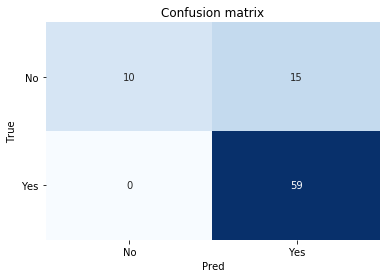

In [730]:
## Plot confusion matrix
cm = metrics.confusion_matrix(df_test['usaid_funded'], predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=('No', 'Yes'), 
       yticklabels=('No', 'Yes'), title="Confusion matrix")
plt.yticks(rotation=0)

### Type of Doc classification based on full-text

#### Synonym list

In [413]:
synonym_type_doc_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\Document Type Synonyms.csv"
synonym_type_doc_df = pd.read_csv(synonym_type_doc_path)
synonym_type_doc_df.head(4)

,Landscape Analysis,Performance evaluation report,Impact Evaluation Report,Use case/case study,Industry Publication,Peer-reviewed article or other research report,Systematic review or Meta-analysis,White Paper/Think Tank Report
0,Landscape assessment,Progress report,Impact,Case Study,Market intelligence,Series,Systematic review,Think tank
1,Rapid assessment,Annual report,Outcomes,Use Case,baseline assessment,Literature,Meta-analysis,Guidance
2,Categorization,Program Report,Impacts,Case examples,"(can we look at author here? written from industry association, organization, conglomerate, etc)",Research,Analysis,NaN
3,Categorizing,Midterm evaluation,Sustained impact evaluation,Case Studies,Solution,Thesis,Comprehensive review,NaN


In [414]:
type_doc_syn_dict = {}
for col in synonym_type_doc_df.columns:
    type_doc_syn_dict[col] = []
    for item in  synonym_type_doc_df[col][synonym_type_doc_df[col].notna()]:
        type_doc_syn_dict[col].append(item)

In [415]:
def search_doc_type(s):
    frequency = {}
    text = ' '.join(s[1:5]) + ' '.join(s[-4:]) 
    for doc_type in type_doc_syn_dict:
        frequency[doc_type] = 0
        for phrase in type_doc_syn_dict[doc_type]:
            frequency[doc_type] += text.lower().count(phrase.lower())
    return max(frequency, key=frequency.get)
        
df_small_text['type_doc_synonym_found'] = df_small_text['full_content'].apply(search_doc_type)
df_text['type_doc_synonym_found'] = df_text['full_content'].apply(search_doc_type)

In [477]:
from sklearn.metrics import accuracy_score
df_text[df_text['type_doc_synonym_found'] == df_text['Type of Document']].shape[0] / df_text.shape[0]

0.40657439446366783

In [416]:
from sklearn.metrics import accuracy_score
df_small_text[df_small_text['type_doc_synonym_found'] == df_small_text['Type of Document']].shape[0] / df_small_text.shape[0]

0.25766871165644173

#### Model

In [488]:
df_text['doc_type_label'], doc_type_uniques = pd.factorize(df_text["Type of Document"])
df_text.head(2)

,doc_name,content,full_content,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,Technical Sector,Special Considerations,Private Sector Industry,Type of Enterprise,Country(ies),USAID Region,USAID-Funded?,Type of Document,PSE Ways We Engage,PSE Key Values,PSE Key Values USAID Offers,Key Findings,Key Recommendations,Document Attachment,Google Drive Link,Internet URL of Document,Reviewer Name,Review Complete?,Review Stage,text_clean,authors_found,found_year,doc_type_label,spec_consideration_labels,technical_sector_labels,countries_found,usaid_region_found,type_doc_synonym_found
0,0000-APLU-PAK.pkl,\n \n \n \n\nAcknowledgements \n\nMany people...,[ \n\n \n\n \n\n \n\nFeasibility Study of th...,0000-APLU-PAK,Feasibility Study of the US-Pakistan Knowledge...,Association for Public and Land-grant Universi...,NaN,USAID,NaN,Education and Social Services,Youth,Educational Services,NaN,Pakistan,Afghanistan and Pakistan,checked,Use case/case study,"Advancing Learning and Market Research;,Harnes...","""Scale, Sustainability, and Reach"",""Innovation...","Sectoral Expertise and Knowledge,Support to St...",We can learn from past individual training pro...,Recommendations for aligning program goals:\n1...,0000-APLU-PAK.pdf (https://dl.airtable.com/.at...,https://drive.google.com/open?id=1foT7HO75eCJ-...,https://pdf.usaid.gov/pdf_docs/PA00N7DN.pdf,"Mehak,Anna",checked,Second Review,acknowledgement many people contributed develo...,"[Landgrant Universities, Erica Rounsefell, Kev...",NaN,0,[Youth],[Education and Social Services],"[Pakistan, United States]",[Asia],Peer-reviewed article or other research report
1,0000-Chile-ZMB.pkl,\n\n \n\n \n\n \n\n \n\nRepublic of Zambia \n...,[ \n\n \n \n\n \n\n \n\n \n\nRepublic of Zambi...,0000-Chile-ZMB,Teacher Effectiveness. Towards Sustainable Del...,"John Chileshe,Geoffrey Tambulukani",NaN,USAID,NaN,Education and Social Services,NaN,NaN,NaN,Zambia,Africa,checked,Use case/case study,"Information-Sharing and Strategic Alignment,Ca...",Efficiency and Effectiveness,Sectoral Expertise and Knowledge,"According to this article, the head teacher is...",The following are examples of key best practic...,0000-Chile-ZMB.pdf (https://dl.airtable.com/.a...,https://drive.google.com/open?id=1dzE6kGKQRTK-...,https://pdf.usaid.gov/pdf_docs/PA00MWT9.pdf,"Mehak,Lauren",checked,Second Review,republic zambia ministry general education tea...,[John Chileshe],NaN,0,[],[Education and Social Services],"[Chile, Japan, United States, Zambia]",[Africa],Peer-reviewed article or other research report


In [489]:
from sklearn.utils import shuffle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

df_text_enriched = df_text[df_text['text_clean'].str.len() > 1000]
print(df_text_enriched.shape)
df_text_enriched = shuffle(df_text_enriched)
df_train, df_test = model_selection.train_test_split(df_text_enriched, test_size=0.15)
## get target
y_train = df_train["doc_type_label"].values
y_test = df_test["doc_type_label"].values

(554, 37)


In [490]:
df_text_enriched['doc_type_label'].value_counts()

 0    207
 2    173
 5    108
 7     19
 8     15
 3     13
 1      9
 6      7
 4      2
-1      1
Name: doc_type_label, dtype: int64

In [491]:
doc_type_uniques

Index(['Use case/case study', 'White Paper/Think Tank Report',
       'Performance evaluation report', 'Systematic review or Meta-analysis',
       'Political Economy Analysis',
       'Peer-reviewed article or other research report',
       'Impact Evaluation Report', 'Industry Publication',
       'Landscape Analysis'],
      dtype='object')

In [492]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [493]:
corpus = df_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [494]:
classifier = LogisticRegression()
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(df_train["text_clean"].values, y_train)
## test
X_test = df_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [495]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test['doc_type_label'], predicted)

0.7619047619047619

In [496]:
# df_test[(df_test['doc_type_label'] == 2) & (df_test['source'] == 'pse')]

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text yticklabel objects>)

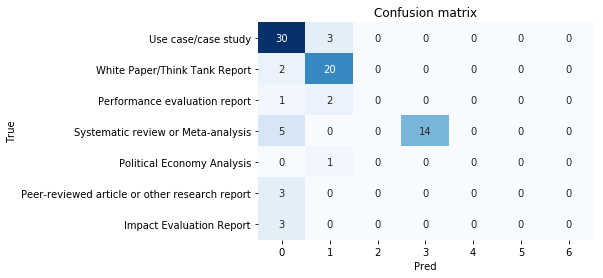

In [497]:
## Plot confusion matrix
cm = metrics.confusion_matrix(df_test['doc_type_label'], predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=range(0, 8), 
       yticklabels=doc_type_uniques, title="Confusion matrix")
plt.yticks(rotation=0)

In [501]:
feature_names = vectorizer.get_feature_names()

def get_ifidf_for_words(text):
    tfidf_matrix= vectorizer.transform([text]).todense()
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
    return dict(tfidf_scores)

text = ' '.join(vectorizer.get_feature_names())

In [502]:
d = get_ifidf_for_words(text)
sorted(d.items(), key=lambda x: x[1], reverse=True)

[('health', 0.23965325877365046),
 ('development', 0.18678826900959836),
 ('project', 0.16046641091756897),
 ('evaluation', 0.15639251713703037),
 ('usaid', 0.1309617423729095),
 ('program', 0.12500216309090026),
 ('water', 0.11243113421471136),
 ('report', 0.10282570155123354),
 ('management', 0.09456607710241112),
 ('support', 0.09288869616652469),
 ('policy', 0.08971332900214428),
 ('sector', 0.08835878117862142),
 ('private', 0.08690641244188925),
 ('public', 0.0862738276125126),
 ('annex', 0.08537355816352958),
 ('research', 0.08366342615322223),
 ('partnership', 0.08321184345638531),
 ('global', 0.0830977672602908),
 ('business', 0.08289960168815702),
 ('social', 0.07518379469505113),
 ('government', 0.07416456686581678),
 ('international', 0.07259332441637166),
 ('farmer', 0.07240558241359965),
 ('community', 0.07095148105325905),
 ('woman', 0.0696493945917954),
 ('agricultural', 0.06857121209086865),
 ('country', 0.06743979332332035),
 ('trade', 0.06687628945543944),
 ('activit

### Special consideration

In [93]:
df_text['spec_consideration_labels'] = df_text['Special Considerations'].str.split(',')
nulls = df_text[pd.isnull(df_text['spec_consideration_labels'])]

for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_text['spec_consideration_labels'].loc[ni] = []
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
spec_consider_coded = mlb.fit_transform(df_text['spec_consideration_labels'])
# df_text.head(2)

C:\Users\Volha_Skidan\Anaconda3\envs\havos\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [94]:
pd.Series([item for sublist in df_text['spec_consideration_labels'] for item in sublist]).value_counts()

Gender & Women's Economic Empowerment    348
Youth                                    274
Conflict                                 130
dtype: int64

In [95]:
print(spec_consider_coded[:2])

[[0 0 1]
 [0 0 0]]


In [96]:
from sklearn.utils import shuffle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

df_text_fts, target = shuffle(df_text['text_clean'], spec_consider_coded)
df_train, df_test, y_train, y_test = model_selection.train_test_split(df_text_fts, target, test_size=0.15)

In [97]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(df_train)
X_train = vectorizer.transform(df_train)
dic_vocabulary = vectorizer.vocabulary_

In [110]:
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(LogisticRegression())
# forest = RandomForestClassifier(random_state=1)
# multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(df_train, y_train)
## test
X_test = df_test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

C:\Users\Volha_Skidan\Anaconda3\envs\havos\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Conflict
0.7586206896551724
Gender & Women's Economic Empowerment
0.7471264367816092
Youth
0.7241379310344828


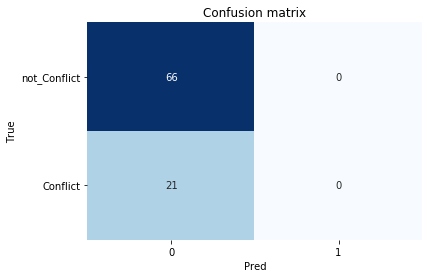

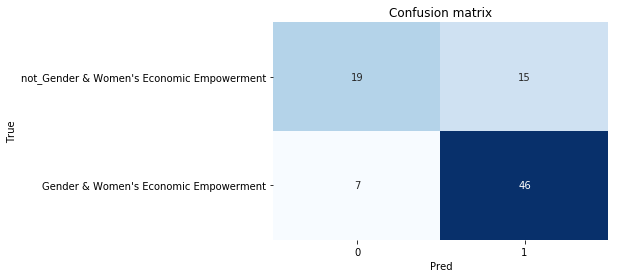

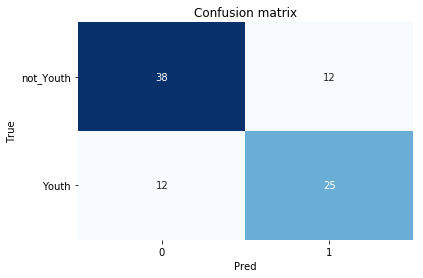

In [118]:
from sklearn.metrics import accuracy_score

# Gender & Women's Economic Empowerment    348
# Youth                                    274
# Conflict                                 130
for i in range(0, 3):
    pred = predicted[:, i]
    prob = predicted_prob[:, i]
    true = y_test[:, i]
    print(mlb.classes_[i])
    print(accuracy_score(true, pred))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=range(0, 2), 
           yticklabels=[f'not_{mlb.classes_[i]}', mlb.classes_[i]], title="Confusion matrix")
    plt.yticks(rotation=0)
    
# OLD
# Conflict
# 0.735632183908046
# Gender & Women's Economic Empowerment
# 0.7126436781609196
# Youth
# 0.7816091954022989

In [119]:
X_test = df_small_text['text_clean'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [122]:
predicted[:, 1]

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1])

In [164]:
df_small_text['gender_woman_empower_predicted'] = predicted[:, 1]
df_small_text['youth_predicted'] = predicted[:, 2]

In [ ]:
np.where(df_small_text['gender_woman_empower_predicted'] == 1, 'Gender - Women’s Economic Empowerment')

#### Dictionary for class assignments

In [136]:
consider_doc_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\spec_consider.xlsx"
spec_cons_df = pd.read_excel(consider_doc_path)
spec_cons_df.head(4)

,Conflict,Gender - Women’s Economic Empowerment,Youth,COVID-19,Cost-benefit,Digital Dev/Finance,Vulnerable
0,Refugee,Gender inclusion,Youth,COVID-19,Cost-effectiveness,Digital development,Emergencies
1,Suffering,Women’s organizations,Youth development,COVID-19 pandemic,Cost-benefit,Digital finance,Vulnerable populations
2,Conflict Resolution,Gender,Youth Empowerment,COVID-19 outbreak,NaN,ITC,Marginalized communities
3,Armed conflict,Empowering women,Youth populations,COVID-19 response,NaN,Mobile Money,People with disabilities


In [230]:
def search_spec_consider(s):
    frequency = {}
    text = ' '.join(s[1:5]) + ' '.join(s[-4:]) 
    for spec in spec_cons_df.columns:
        if spec == 'COVID-19':
            continue
        frequency[spec] = 0
        for phrase in spec_cons_df[spec]:
            if str(phrase) == 'nan':
                continue
            frequency[spec] += text.lower().count(phrase.lower())
    freq_sum = sum(frequency.values())
    spec_list = set()
    
    for k, v in frequency.items():
        if (v > 1 and k != 'Conflict') or (k == 'Conflict' and v > 10):
            spec_list.add(k)
#     print(frequency)
    return list(spec_list)
#     return max(frequency, key=frequency.get)
        
df_small_text['spec_consider_found'] = df_small_text['full_content'].apply(search_spec_consider)
df_text['spec_consider_found'] = df_text['full_content'].apply(search_spec_consider)

In [231]:
mapping = {'Conflict' : 'BB3_Conflict',
'Cost-benefit':'BB3_Cost-Benefit',
'Digital Dev/Finance':'BB3_Digital Dev/Finance',
'Gender - Women’s Economic Empowerment':'BB3_Gender',
'Vulnerable':'BB3_Vulnerable',
'Youth':'BB3_Youth'}

def mapping_to_codes(s):
    labels=set()
    for label in s:
        labels.add(mapping[label])
    return list(labels)

In [232]:
df_small_text['B3_USAID Themes'] = df_small_text['spec_consider_found']
df_small_text['B3_USAID Themes'] = np.where(df_small_text['gender_woman_empower_predicted'] == 1, df_small_text['B3_USAID Themes'] + ['Gender - Women’s Economic Empowerment' for x in range(163)], df_small_text['B3_USAID Themes']) 
df_small_text['B3_USAID Themes'] = np.where(df_small_text['youth_predicted'] == 1, df_small_text['B3_USAID Themes'] + ['Youth' for x in range(163)], df_small_text['B3_USAID Themes']) 
# df_small_text['B3_USAID Themes'] = df_small_text['B3_USAID Themes'].apply(lambda x: list(set(x)))
df_small_text['B3_USAID Themes'] = df_small_text['B3_USAID Themes'].apply(mapping_to_codes)

In [233]:
df_small_text[['B3_USAID Themes', 'Special Considerations']]

,B3_USAID Themes,Special Considerations
0,[],NaN
1,[BB3_Conflict],Conflict
2,"[BB3_Gender, BB3_Conflict, BB3_Digital Dev/Fin...",NaN
3,"[BB3_Gender, BB3_Conflict, BB3_Digital Dev/Fin...",NaN
4,"[BB3_Gender, BB3_Conflict, BB3_Digital Dev/Fin...",NaN
5,[],NaN
6,"[BB3_Gender, BB3_Conflict]",NaN
7,[BB3_Gender],NaN
8,"[BB3_Gender, BB3_Digital Dev/Finance]",NaN
9,[],NaN


#### Special considaration work frequency

In [702]:
from collections import defaultdict
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')
from plotly import tools
import plotly.offline as py

train_y_df = df_text[df_text["spec_consideration_labels"].apply(lambda x: 'Youth' in x)]
# train_w_df = df_text[df_text["spec_consideration_labels"].apply(lambda x: "Gender & Women's Economic Empowerment" in x)]
train_w_df = df_text[df_text["spec_consideration_labels"].apply(lambda x: "Conflict" in x)]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in lst_stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train_y_df["text_clean"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace_y = horizontal_bar_chart(fd_sorted.head(30), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train_w_df["text_clean"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace_w = horizontal_bar_chart(fd_sorted.head(30), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of Youth", 
                                          "Frequent words of Conflict"])
fig.append_trace(trace_y, 1, 1)
fig.append_trace(trace_w, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

In [468]:
feature_names = vectorizer.get_feature_names()

def get_ifidf_for_words(text):
    tfidf_matrix= vectorizer.transform([text]).todense()
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
    return dict(tfidf_scores)

text = ' '.join(vectorizer.get_feature_names())

In [471]:
d = get_ifidf_for_words(text)
sorted(d.items(), key=lambda x: x[1], reverse=True)

[('health', 0.23540778412351007),
 ('development', 0.17592530980483445),
 ('evaluation', 0.1592862924493641),
 ('project', 0.15756118221975973),
 ('program', 0.140604369373423),
 ('usaid', 0.12577981616847395),
 ('sector', 0.10327247084532855),
 ('support', 0.0956413556997685),
 ('private', 0.09428723143013878),
 ('management', 0.09347348300466578),
 ('report', 0.09280881134459822),
 ('policy', 0.0908707067582535),
 ('annex', 0.08757504683601318),
 ('global', 0.08285290115012253),
 ('research', 0.08079371051059718),
 ('water', 0.08055964281710945),
 ('business', 0.07946149308452477),
 ('woman', 0.07942689878095684),
 ('government', 0.07637188582541354),
 ('farmer', 0.07620163050157913),
 ('activity', 0.07597792264416788),
 ('partnership', 0.07398553046867425),
 ('country', 0.07269656540660278),
 ('social', 0.07111888371395376),
 ('trade', 0.07048373357789223),
 ('international', 0.07027085998859346),
 ('service', 0.068991723975257),
 ('public', 0.06898818830936929),
 ('community', 0.06

### Technical sector

In [643]:
# df_text['Technical Sector'].value_counts()
df_text['technical_sector_labels'] = df_text['Technical Sector'].str.split(',')
nulls = df_text[pd.isnull(df_text['technical_sector_labels'])]

for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_text['technical_sector_labels'].loc[ni] = []
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tech_sec_coded = mlb.fit_transform(df_text['technical_sector_labels'])
# df_text.head(2)

In [651]:
pd.Series([item for sublist in df_text['technical_sector_labels'] for item in sublist]).value_counts()

Economic Growth                  221
Health                           178
Agriculture and Food Security    122
Environment/Climate Change       94 
 & Governance"                   67 
"Democracy                       67 
 Human Rights                    67 
Education and Social Services    62 
Humanitarian Assistance          18 
Peace & Security                 12 
dtype: int64

In [645]:
tech_sec_coded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [646]:
mlb.classes_

array([' & Governance"', ' Human Rights', '"Democracy',
       'Agriculture and Food Security', 'Economic Growth',
       'Education and Social Services', 'Environment/Climate Change',
       'Health ', 'Humanitarian Assistance', 'Peace & Security'],
      dtype=object)

In [647]:
from sklearn.utils import shuffle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

df_text_fts, target = shuffle(df_text['text_clean'], tech_sec_coded)
df_train, df_test, y_train, y_test = model_selection.train_test_split(df_text_fts, target, test_size=0.15)

In [648]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(df_train)
X_train = vectorizer.transform(df_train)
dic_vocabulary = vectorizer.vocabulary_

In [649]:
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(LogisticRegression())
# forest = RandomForestClassifier(random_state=1)
# multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(df_train, y_train)
## test
X_test = df_test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

0.9310344827586207
0.9310344827586207
0.9310344827586207
0.8275862068965517
0.8160919540229885
0.9540229885057471
0.7816091954022989
0.8275862068965517
0.9655172413793104
0.9770114942528736


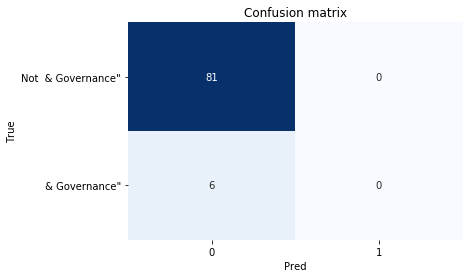

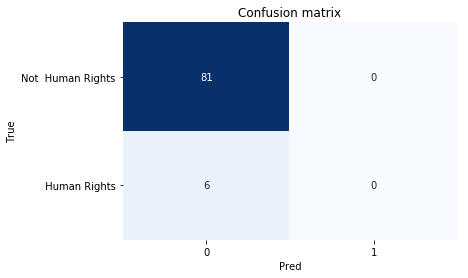

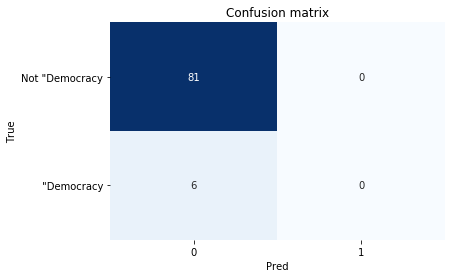

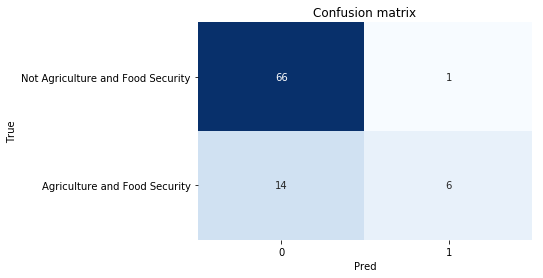

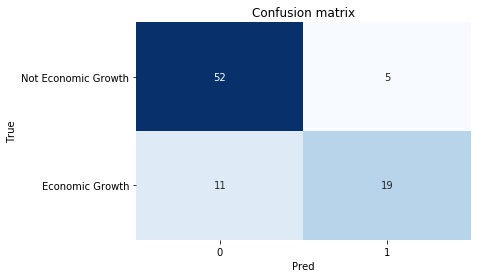

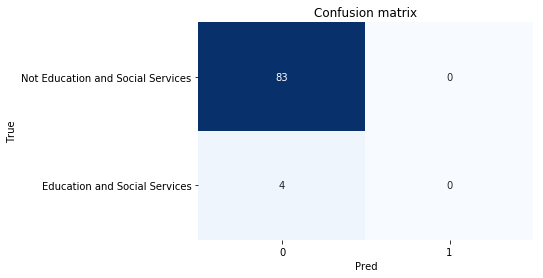

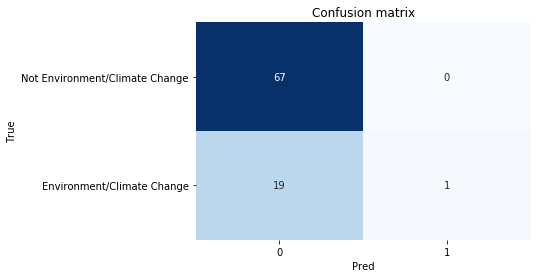

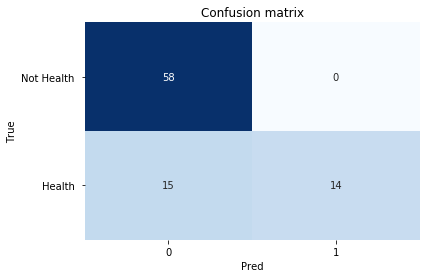

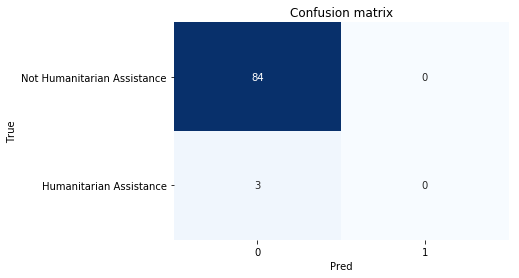

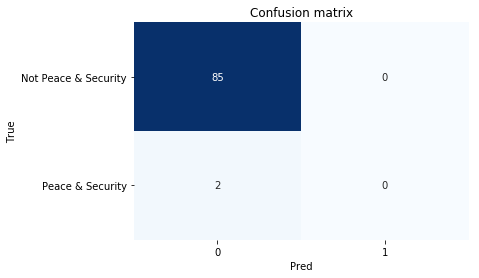

In [650]:
from sklearn.metrics import accuracy_score

# Gender & Women's Economic Empowerment    348
# Youth                                    274
# Conflict                                 130
for i in range(0, 10):
    pred = predicted[:, i]
    prob = predicted_prob[:, i]
    true = y_test[:, i]
    print(accuracy_score(true, pred))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=range(0, 2), 
           yticklabels=[f'Not {mlb.classes_[i]}', mlb.classes_[i]], title="Confusion matrix")
    plt.yticks(rotation=0)

### PSE Ways We Engaged

In [79]:
df_small_text.head(2)

,doc_name,content,full_content,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,Technical Sector,...,text_clean,document_name,Unnamed: 0,title_found,authors_organizations,authors_institutions,publishing_institutions,found_year,countries_found,countries_limited_by_freq_found
0,0000-BOURI-GLO.pkl,USAID’s Center for Innovation and Impact (CII)...,[Unleashing Private \nCapital for Global \nHea...,0000-bouri-glo,Unleashing Private Capital for Global Health I...,Center for Innovation and Impact,NaN,USAID From the American People,NaN,"Humanitarian Assistance,Health",...,usaids center innovation impact cii take busin...,0000-BOURI-GLO,1,Unleashing private capital for global health i...,{'USAID'},{'Amit Bouri'},{'USAID'},NaN,"{'Bangladesh': 1, 'Canada': 4, 'China': 1, 'Co...","[Canada, India, Kenya, Rwanda, Uganda]"
1,0000-CARBO-GLO.pkl,Privatisation and outsourcing in wartime: the ...,[Privatisation and outsourcing in \nwartime: t...,0000-carbo-glo,Privatisation and Outsourcing in Wartime: the ...,Gilles Carbonnier,NaN,Overseas Development Institute,2006.0,"Humanitarian Assistance,Peace & Security,""Demo...",...,privatisation outsourcing wartime humanitarian...,0000-CARBO-GLO,2,Privatisation and outsourcing in wartime: the ...,set(),{'Gilles Carbonnier'},set(),2000.0,"{'Afghanistan': 2, 'Argentina': 1, 'Australia'...","[Afghanistan, Switzerland, United Kingdom, Gua..."


In [93]:
# df_text['Technical Sector'].value_counts()
df_small_text['pse_wwe_labels'] = df_small_text['PSE Ways We Engage'].str.split(',')
nulls = df_small_text[pd.isnull(df_small_text['pse_wwe_labels'])]

for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_small_text['pse_wwe_labels'].loc[ni] = []
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tech_ways_coded = mlb.fit_transform(df_small_text['pse_wwe_labels'])
# df_text.head(2)

C:\Users\Volha_Skidan\AppData\Local\Temp\ipykernel_6324\3861989912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small_text['pse_wwe_labels'].loc[ni] = []


In [94]:
pd.Series([item for sublist in df_small_text['pse_wwe_labels'] for item in sublist]).value_counts()

Harnessing Private-Sector Expertise and Innovation;    90
Catalyzing Private-Sector Resources;                   87
Information-Sharing and Strategic Alignment            56
Strengthening the Enabling Environment                 55
Advancing Learning and Market Research;                26
dtype: int64

In [95]:
tech_ways_coded

array([[0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 1, 1, 1],
       [0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 1, 0, 1],
       [0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1,

In [96]:
mlb.classes_

array(['Advancing Learning and Market Research;',
       'Catalyzing Private-Sector Resources;',
       'Harnessing Private-Sector Expertise and Innovation;',
       'Information-Sharing and Strategic Alignment',
       'Strengthening the Enabling Environment'], dtype=object)

In [97]:
from sklearn.utils import shuffle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

df_text_fts, target = shuffle(df_small_text['text_clean'], tech_ways_coded)
df_train, df_test, y_train, y_test = model_selection.train_test_split(df_text_fts, target, test_size=0.15)

In [101]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(df_train)
X_train = vectorizer.transform(df_train)
dic_vocabulary = vectorizer.vocabulary_

In [142]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=10))
# forest = RandomForestClassifier(random_state=1)
# multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(df_train, y_train)
## test
X_test = df_test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

0.8735632183908046
0.6781609195402298
0.6551724137931034
0.5632183908045977
0.7586206896551724


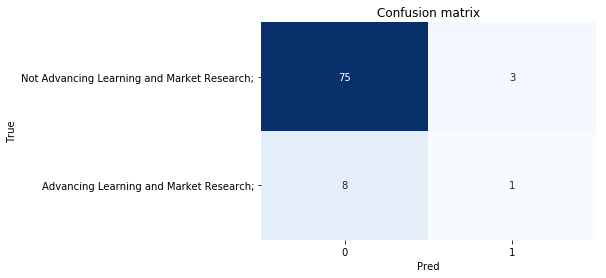

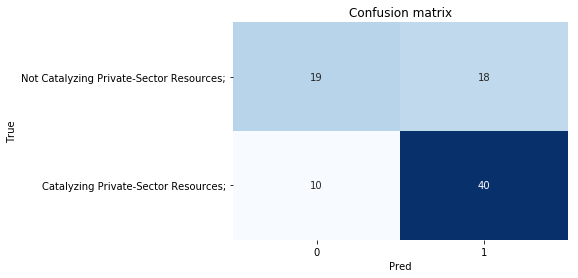

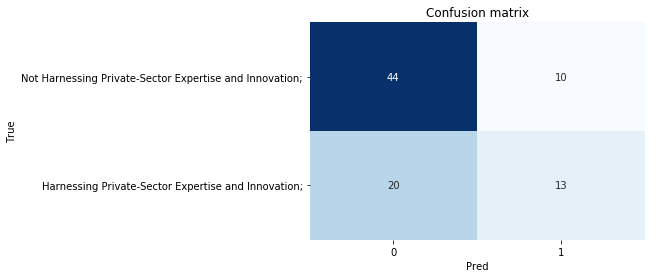

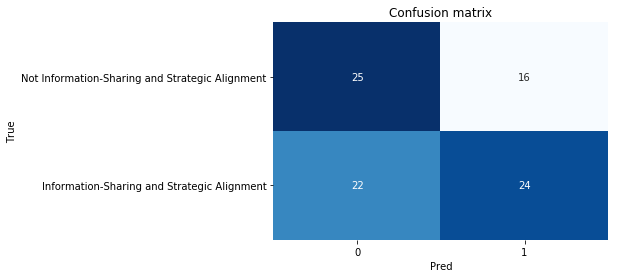

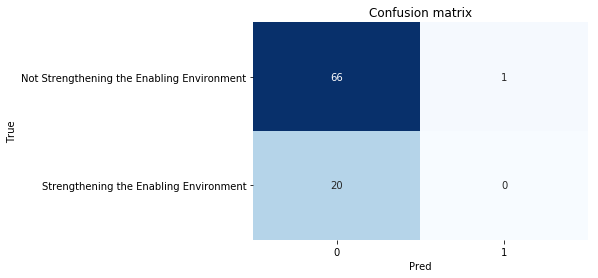

In [143]:
from sklearn.metrics import accuracy_score

for i in range(0, 5):
    pred = predicted[:, i]
    prob = predicted_prob[:, i]
    true = y_test[:, i]
    print(accuracy_score(true, pred))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=range(0, 2), 
           yticklabels=[f'Not {mlb.classes_[i]}', mlb.classes_[i]], title="Confusion matrix")
    plt.yticks(rotation=0)

In [144]:
predicted_full = model.predict(df_text['text_clean'])
predicted_proba_full = model.predict_proba(df_text['text_clean'])

In [145]:
predicted_full.shape

(578, 5)

In [146]:
df_text.shape

(578, 37)

In [147]:
df_text["pse_ways_predicted"] = None
df_text["pse_ways_probability_predicted"] = None

In [148]:
for i in range(predicted_full.shape[0]):
    df_text["pse_ways_predicted"].values[i] = []
    df_text["pse_ways_probability_predicted"].values[i] = {}
    for j in range(5):
        label = mlb.classes_[j]
        if predicted_full[i][j] == 1:
            df_text["pse_ways_predicted"].values[i].append(label)
        df_text["pse_ways_probability_predicted"].values[i][label] = predicted_proba_full[i][j]

In [149]:
similar_spans = pd.read_csv("tmp.csv")

In [151]:
df_model = df_text[['doc_name', 'pse_ways_predicted', 'pse_ways_probability_predicted']]

df_enriched = pd.merge(similar_spans,
                      df_model,
                      on='doc_name',
                      how='inner')

In [152]:
df_enriched.to_csv("pse_ways_comparison.csv")

### PSE Key Values

In [272]:
df_text.head(2)

,doc_name,content,full_content,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,Technical Sector,Special Considerations,Private Sector Industry,Type of Enterprise,Country(ies),USAID Region,USAID-Funded?,Type of Document,PSE Ways We Engage,PSE Key Values,PSE Key Values USAID Offers,Key Findings,Key Recommendations,Document Attachment,Google Drive Link,Internet URL of Document,Reviewer Name,Review Complete?,Review Stage,text_clean,authors_found,found_year,priv_sect_partners_found,spec_consideration_labels,pse_wwe_labels,pse_ways_labels,pse_ways_predicted,pse_ways_probability_predicted,pse_keys_labels,PSE_key_values,pse_keys_offer_labels
0,0000-APLU-PAK.pkl,\n \n \n \n\nAcknowledgements \n\nMany people...,[ \n\n \n\n \n\n \n\nFeasibility Study of th...,0000-APLU-PAK,Feasibility Study of the US-Pakistan Knowledge...,Association for Public and Land-grant Universi...,NaN,USAID,NaN,Education and Social Services,Youth,Educational Services,NaN,Pakistan,Afghanistan and Pakistan,checked,Use case/case study,"Advancing Learning and Market Research;,Harnes...","""Scale, Sustainability, and Reach"",""Innovation...","Sectoral Expertise and Knowledge,Support to St...",We can learn from past individual training pro...,Recommendations for aligning program goals:\n1...,0000-APLU-PAK.pdf (https://dl.airtable.com/.at...,https://drive.google.com/open?id=1foT7HO75eCJ-...,https://pdf.usaid.gov/pdf_docs/PA00N7DN.pdf,"Mehak,Anna",checked,Second Review,acknowledgement many people contributed develo...,"[Landgrant Universities, Erica Rounsefell, Kev...",NaN,"[BT, Ecom, GOAL, Google, Intel, PATH, SIM, UPS...",[Youth],"[Advancing Learning and Market Research;, Harn...","[Advancing Learning and Market Research;, Harn...","[Advancing Learning and Market Research;, Harn...",{'Advancing Learning and Market Research;': 0....,"[Scale, Sustainability, and Reach, Innovation,...","Scale, Sustainability, and Reach;Innovation, E...","[Sectoral Expertise and Knowledge, Support to ..."
1,0000-Chile-ZMB.pkl,\n\n \n\n \n\n \n\n \n\nRepublic of Zambia \n...,[ \n\n \n \n\n \n\n \n\n \n\nRepublic of Zambi...,0000-Chile-ZMB,Teacher Effectiveness. Towards Sustainable Del...,"John Chileshe,Geoffrey Tambulukani",NaN,USAID,NaN,Education and Social Services,NaN,NaN,NaN,Zambia,Africa,checked,Use case/case study,"Information-Sharing and Strategic Alignment,Ca...",Efficiency and Effectiveness,Sectoral Expertise and Knowledge,"According to this article, the head teacher is...",The following are examples of key best practic...,0000-Chile-ZMB.pdf (https://dl.airtable.com/.a...,https://drive.google.com/open?id=1dzE6kGKQRTK-...,https://pdf.usaid.gov/pdf_docs/PA00MWT9.pdf,"Mehak,Lauren",checked,Second Review,republic zambia ministry general education tea...,[John Chileshe],NaN,"[Amul, Creative Associates International, SIM,...",[],"[Information-Sharing and Strategic Alignment, ...","[Information-Sharing and Strategic Alignment, ...","[Catalyzing Private-Sector Resources;, Informa...",{'Advancing Learning and Market Research;': 0....,[Efficiency and Effectiveness],Efficiency and Effectiveness,[Sectoral Expertise and Knowledge]


In [273]:
def replace_inner_commas(s):
    cur = False
    s = list(str(s))
    for i in range(len(s)):
        ch = s[i]
        if ch == ',' and cur == True:
            s[i] = '+'
            continue
        if ch == '"' and cur == False:
            cur = True
            continue
        if ch == '"' and cur == True:
            cur = False
    s = ''.join(s)
    s = s.replace('"', '').replace(',', ';').replace('+', ',')
    if 'nan' in s:
        s = ''
    return s

df_text['PSE_key_values'] = df_text['PSE Key Values'].apply(replace_inner_commas)

In [274]:
# df_text['Technical Sector'].value_counts()
df_text['pse_keys_labels'] = df_text['PSE_key_values'].str.split(';')

for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_text['pse_keys_labels'].loc[ni] = []
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tech_keys_coded = mlb.fit_transform(df_text['pse_keys_labels'])
# df_text.head(2)

In [275]:
pd.Series([item for sublist in df_text['pse_keys_labels'] for item in sublist]).value_counts()

Scale, Sustainability, and Reach           344
Innovation, Expertise, and Capabilities    243
Efficiency and Effectiveness               193
Ability to Influence Policy                 83
                                            56
Flexibility and Pace                        37
dtype: int64

In [276]:
tech_keys_coded

array([[0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1],
       ...,
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0]])

In [277]:
mlb.classes_

array(['', 'Ability to Influence Policy', 'Efficiency and Effectiveness',
       'Flexibility and Pace', 'Innovation, Expertise, and Capabilities',
       'Scale, Sustainability, and Reach'], dtype=object)

In [278]:
from sklearn.utils import shuffle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

df_text_fts, target = shuffle(df_text['text_clean'], tech_keys_coded)
df_train, df_test, y_train, y_test = model_selection.train_test_split(df_text_fts, target, test_size=0.15)

In [279]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(df_train)
X_train = vectorizer.transform(df_train)
dic_vocabulary = vectorizer.vocabulary_

In [280]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

classifier = OneVsRestClassifier(LogisticRegression())
# forest = RandomForestClassifier(random_state=1)
# multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(df_train, y_train)
## test
X_test = df_test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

0.8850574712643678
0.7816091954022989
0.8850574712643678
0.5862068965517241
0.6206896551724138


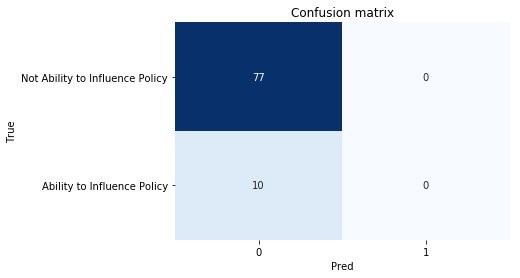

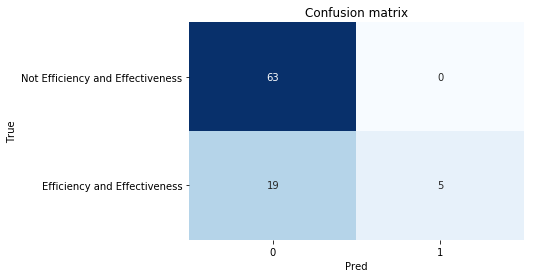

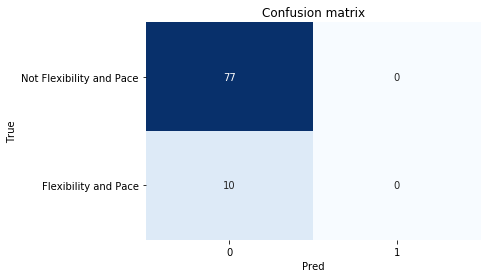

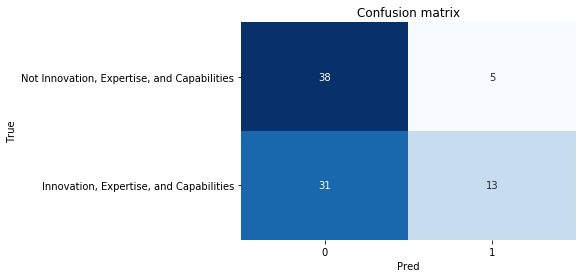

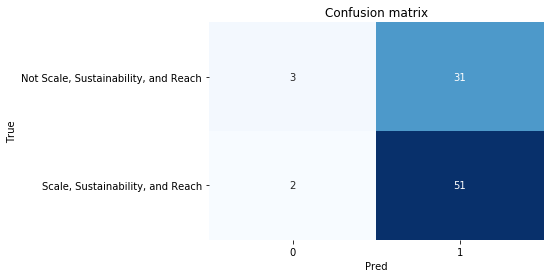

In [281]:
from sklearn.metrics import accuracy_score

for i in range(1, 6):
    pred = predicted[:, i]
    prob = predicted_prob[:, i]
    true = y_test[:, i]
    print(accuracy_score(true, pred))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=range(0, 2), 
           yticklabels=[f'Not {mlb.classes_[i]}', mlb.classes_[i]], title="Confusion matrix")
    plt.yticks(rotation=0)

In [282]:
predicted_full = model.predict(df_text['text_clean'])
predicted_proba_full = model.predict_proba(df_text['text_clean'])

In [283]:
predicted_full.shape

(578, 6)

In [284]:
df_text.shape

(578, 40)

In [286]:
df_text["pse_keys_predicted"] = None
df_text["pse_keys_probability_predicted"] = None

In [287]:
for i in range(predicted_full.shape[0]):
    df_text["pse_keys_predicted"].values[i] = []
    df_text["pse_keys_probability_predicted"].values[i] = {}
    for j in range(1,6):
        label = mlb.classes_[j]
        if predicted_full[i][j] == 1:
            df_text["pse_keys_predicted"].values[i].append(label)
        df_text["pse_keys_probability_predicted"].values[i][label] = predicted_proba_full[i][j]

In [288]:
similar_spans = pd.read_csv("tmp_keys_pse.csv")

In [289]:
df_model = df_text[['doc_name', 'pse_keys_predicted', 'pse_keys_probability_predicted']]

df_enriched = pd.merge(similar_spans,
                      df_model,
                      on='doc_name',
                      how='inner')

In [290]:
df_enriched.to_csv("pse_keys_comparison.csv")

### PSE Key Values USAID Offers

In [291]:
df_text.head(2)

,doc_name,content,full_content,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,Technical Sector,Special Considerations,Private Sector Industry,Type of Enterprise,Country(ies),USAID Region,USAID-Funded?,Type of Document,PSE Ways We Engage,PSE Key Values,PSE Key Values USAID Offers,Key Findings,Key Recommendations,Document Attachment,Google Drive Link,Internet URL of Document,Reviewer Name,Review Complete?,Review Stage,text_clean,authors_found,found_year,priv_sect_partners_found,spec_consideration_labels,pse_wwe_labels,pse_ways_labels,pse_ways_predicted,pse_ways_probability_predicted,pse_keys_labels,PSE_key_values,pse_keys_offer_labels,pse_keys_predicted,pse_keys_probability_predicted
0,0000-APLU-PAK.pkl,\n \n \n \n\nAcknowledgements \n\nMany people...,[ \n\n \n\n \n\n \n\nFeasibility Study of th...,0000-APLU-PAK,Feasibility Study of the US-Pakistan Knowledge...,Association for Public and Land-grant Universi...,NaN,USAID,NaN,Education and Social Services,Youth,Educational Services,NaN,Pakistan,Afghanistan and Pakistan,checked,Use case/case study,"Advancing Learning and Market Research;,Harnes...","""Scale, Sustainability, and Reach"",""Innovation...","Sectoral Expertise and Knowledge,Support to St...",We can learn from past individual training pro...,Recommendations for aligning program goals:\n1...,0000-APLU-PAK.pdf (https://dl.airtable.com/.at...,https://drive.google.com/open?id=1foT7HO75eCJ-...,https://pdf.usaid.gov/pdf_docs/PA00N7DN.pdf,"Mehak,Anna",checked,Second Review,acknowledgement many people contributed develo...,"[Landgrant Universities, Erica Rounsefell, Kev...",NaN,"[BT, Ecom, GOAL, Google, Intel, PATH, SIM, UPS...",[Youth],"[Advancing Learning and Market Research;, Harn...","[Advancing Learning and Market Research;, Harn...","[Advancing Learning and Market Research;, Harn...",{'Advancing Learning and Market Research;': 0....,"[Scale, Sustainability, and Reach, Innovation,...","Scale, Sustainability, and Reach;Innovation, E...","[Sectoral Expertise and Knowledge, Support to ...","[Scale, Sustainability, and Reach]",{'Ability to Influence Policy': 0.140421245890...
1,0000-Chile-ZMB.pkl,\n\n \n\n \n\n \n\n \n\nRepublic of Zambia \n...,[ \n\n \n \n\n \n\n \n\n \n\nRepublic of Zambi...,0000-Chile-ZMB,Teacher Effectiveness. Towards Sustainable Del...,"John Chileshe,Geoffrey Tambulukani",NaN,USAID,NaN,Education and Social Services,NaN,NaN,NaN,Zambia,Africa,checked,Use case/case study,"Information-Sharing and Strategic Alignment,Ca...",Efficiency and Effectiveness,Sectoral Expertise and Knowledge,"According to this article, the head teacher is...",The following are examples of key best practic...,0000-Chile-ZMB.pdf (https://dl.airtable.com/.a...,https://drive.google.com/open?id=1dzE6kGKQRTK-...,https://pdf.usaid.gov/pdf_docs/PA00MWT9.pdf,"Mehak,Lauren",checked,Second Review,republic zambia ministry general education tea...,[John Chileshe],NaN,"[Amul, Creative Associates International, SIM,...",[],"[Information-Sharing and Strategic Alignment, ...","[Information-Sharing and Strategic Alignment, ...","[Catalyzing Private-Sector Resources;, Informa...",{'Advancing Learning and Market Research;': 0....,[Efficiency and Effectiveness],Efficiency and Effectiveness,[Sectoral Expertise and Knowledge],"[Scale, Sustainability, and Reach]",{'Ability to Influence Policy': 0.116197455655...


In [292]:
# df_text['Technical Sector'].value_counts()
df_text['pse_keys_offer_labels'] = df_text['PSE Key Values USAID Offers'].str.split(',')
nulls = df_text[pd.isnull(df_text['pse_keys_offer_labels'])]

for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_text['pse_keys_offer_labels'].loc[ni] = []
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tech_keys_offer_coded = mlb.fit_transform(df_text['pse_keys_offer_labels'])
# df_text.head(2)

In [293]:
pd.Series([item for sublist in df_text['pse_keys_offer_labels'] for item in sublist]).value_counts()

Strong In-Country Networks and Relationships    240
Sectoral Expertise and Knowledge                207
Support to Strengthen Enabling Environments     176
Reputation and Credible Convening Power          90
Risk-Mitigation and Flexible Authorities         58
dtype: int64

In [294]:
tech_keys_offer_coded

array([[0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 0, 1, 0, 1]])

In [295]:
mlb.classes_

array(['Reputation and Credible Convening Power',
       'Risk-Mitigation and Flexible Authorities',
       'Sectoral Expertise and Knowledge',
       'Strong In-Country Networks and Relationships',
       'Support to Strengthen Enabling Environments'], dtype=object)

In [296]:
from sklearn.utils import shuffle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

df_text_fts, target = shuffle(df_text['text_clean'], tech_keys_offer_coded)
df_train, df_test, y_train, y_test = model_selection.train_test_split(df_text_fts, target, test_size=0.15)

In [297]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(df_train)
X_train = vectorizer.transform(df_train)
dic_vocabulary = vectorizer.vocabulary_

In [298]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

classifier = OneVsRestClassifier(LogisticRegression())
# forest = RandomForestClassifier(random_state=1)
# multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(df_train, y_train)
## test
X_test = df_test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

0.8275862068965517
0.9425287356321839
0.6781609195402298
0.6091954022988506
0.6666666666666666


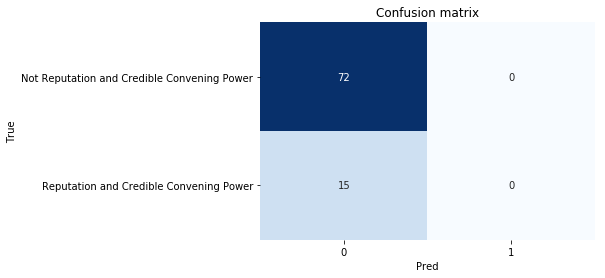

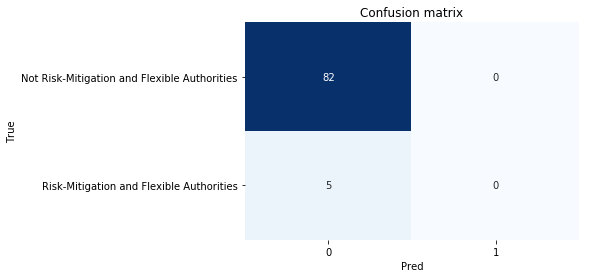

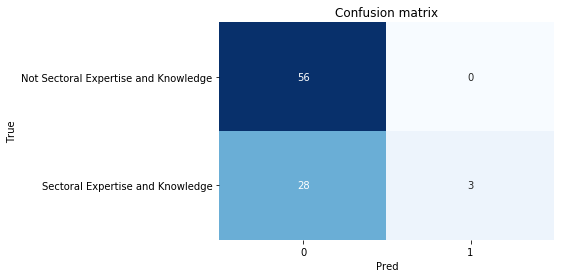

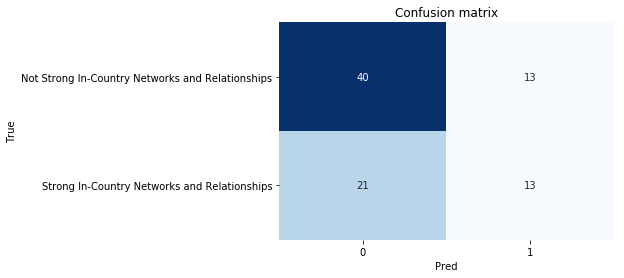

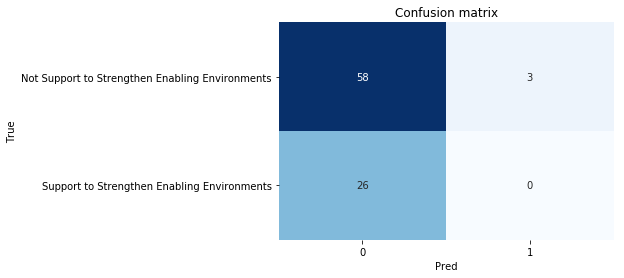

In [299]:
from sklearn.metrics import accuracy_score

for i in range(5):
    pred = predicted[:, i]
    prob = predicted_prob[:, i]
    true = y_test[:, i]
    print(accuracy_score(true, pred))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=range(0, 2), 
           yticklabels=[f'Not {mlb.classes_[i]}', mlb.classes_[i]], title="Confusion matrix")
    plt.yticks(rotation=0)

In [300]:
predicted_full = model.predict(df_text['text_clean'])
predicted_proba_full = model.predict_proba(df_text['text_clean'])

In [301]:
predicted_full.shape

(578, 5)

In [302]:
df_text.shape

(578, 42)

In [303]:
df_text["pse_keys_offer_predicted"] = None
df_text["pse_keys_offer_probability_predicted"] = None

In [305]:
for i in range(predicted_full.shape[0]):
    df_text["pse_keys_offer_predicted"].values[i] = []
    df_text["pse_keys_offer_probability_predicted"].values[i] = {}
    for j in range(5):
        label = mlb.classes_[j]
        if predicted_full[i][j] == 1:
            df_text["pse_keys_offer_predicted"].values[i].append(label)
        df_text["pse_keys_offer_probability_predicted"].values[i][label] = predicted_proba_full[i][j]

In [306]:
similar_spans = pd.read_csv("tmp_keys_offer_pse.csv")

In [307]:
df_model = df_text[['doc_name', 'pse_keys_offer_predicted', 'pse_keys_offer_probability_predicted']]

df_enriched = pd.merge(similar_spans,
                      df_model,
                      on='doc_name',
                      how='inner')

In [308]:
df_enriched.to_csv("pse_keys_offer_comparison.csv")

### Student spans tests (run in different notebook with different env)

In [34]:
spans_categories_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\PSE BHA Materials Inventory - BHA Student Notes.csv"
spans_categories_doc_df = pd.read_csv(spans_categories_path)
spans_categories_doc_df.head(4)

,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6
0,0000-BOM-GLO,14,ÉLAN RDC has laid the foundations for the appl...,PSE Key Values,"Innovation, Expertise, and Capabilities",NO,NaN
1,0000-BOM-GLO,9,Case Study: Using Mobile Money for Cash Transfers,Type of Document,Use Case / Case Study,NaN,NaN
2,0000-BOM-GLO,14,As international trends shift toward greater i...,PSE Ways We Engage,Strengthening the Enabling Environment,NaN,NaN
3,0000-BOM-GLO,1,Recognizing the limited lifespan of any one pr...,PSE Key Values USAID Offers,Sectoral Expertise and Knowledge,NaN,NaN


In [35]:
spans_categories_doc_df['Category '].unique()

array(['PSE Key Values', 'Type of Document', 'PSE Ways We Engage',
       'PSE Key Values USAID Offers', 'Private Sector Industry',
       'Technical Sector', 'Key Recommendations ', nan,
       'Type of Enterprise', 'Key Findings ', 'PSE Values USAID Offers',
       'Private Sector Industry ', 'Special Considerations',
       'Key Findings', 'Key Recommedations', 'Key Recommendations',
       'Type of Enterprise ', 'PSE Key Values ', 'USAID-funded? ',
       'Document Type', 'Type Of Enterprise', 'Special Consideration',
       'Special considerations', 'Technical Sector ',
       'Private Sector Indsutry'], dtype=object)

In [36]:
spans_categories_doc_df = spans_categories_doc_df[spans_categories_doc_df['Category '].notna()]

#### PSE ways we engaged

In [37]:
spans_categories_doc_df['Category '].unique()

array(['PSE Key Values', 'Type of Document', 'PSE Ways We Engage',
       'PSE Key Values USAID Offers', 'Private Sector Industry',
       'Technical Sector', 'Key Recommendations ', 'Type of Enterprise',
       'Key Findings ', 'PSE Values USAID Offers',
       'Private Sector Industry ', 'Special Considerations',
       'Key Findings', 'Key Recommedations', 'Key Recommendations',
       'Type of Enterprise ', 'PSE Key Values ', 'USAID-funded? ',
       'Document Type', 'Type Of Enterprise', 'Special Consideration',
       'Special considerations', 'Technical Sector ',
       'Private Sector Indsutry'], dtype=object)

In [38]:
pse_ways_ex_df = spans_categories_doc_df[spans_categories_doc_df['Category '].isin(['PSE Ways We Engage'])]
print(pse_ways_ex_df.shape)
pse_ways_ex_df.head(3)

(204, 7)


,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6
2,0000-BOM-GLO,14,As international trends shift toward greater i...,PSE Ways We Engage,Strengthening the Enabling Environment,NaN,NaN
8,0000-BOURI-GLO,7,we can encourage transformative innovation and...,PSE Ways We Engage,Harnessing Private Sector Expertise & Innovation,NaN,NaN
9,0000-BOURI-GLO,8,blended finance and/or technical assistance (T...,PSE Ways We Engage,Catalyzing Private Sector Resources,NaN,NaN


In [39]:
pse_ways_ex_df['Label '].value_counts()

Harnessing Private Sector Expertise & Innovation       45
Catalyzing Private Sector Resources                    41
Strengthening the Enabling Environment                 40
Information-Sharing & Strategic Alignment              27
Advanced Learning & Market Research                    21
Harnessing Private-Sector Expertise and Innovation     11
Catalyzing Private-Sector Resources                    10
Strengthening the Enabling Environment                  5
Information-Sharing and Strategic Alignment             1
Strengthen the Enabling Environment                     1
Harnessing Private-Sector Expertise                     1
Harnessing Private-Sector Expertise and Innovation      1
Name: Label , dtype: int64

In [40]:
df_small_text['pse_ways_labels'] = df_small_text['PSE Ways We Engage'].str.split(',')
nulls = df_small_text[pd.isnull(df_small_text['pse_ways_labels'])]
for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_small_text['pse_ways_labels'].loc[ni] = []
pd.Series([item for sublist in df_small_text['pse_ways_labels'] for item in sublist]).value_counts()

C:\Users\Volha_Skidan\AppData\Local\Temp\ipykernel_40496\316221415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small_text['pse_ways_labels'].loc[ni] = []


Harnessing Private-Sector Expertise and Innovation;    90
Catalyzing Private-Sector Resources;                   87
Information-Sharing and Strategic Alignment            56
Strengthening the Enabling Environment                 55
Advancing Learning and Market Research;                26
dtype: int64

In [41]:
ways_list = pd.Series([item for sublist in df_small_text['pse_ways_labels'] for item in sublist]).value_counts().index

In [42]:
ways_list

Index(['Harnessing Private-Sector Expertise and Innovation;',
       'Catalyzing Private-Sector Resources;',
       'Information-Sharing and Strategic Alignment',
       'Strengthening the Enabling Environment',
       'Advancing Learning and Market Research;'],
      dtype='object')

In [43]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [44]:
model_rob = SentenceTransformer('all-distilroberta-v1')

In [45]:
def find_the_closest_ways(s):
    for way in ways_list:
        if s[:5] == way[:5]:
            return way
    return None

def get_vector(s):
    s = str(s).replace("\n", '').replace("\t", "")
    span = model_rob.encode(s)
    return span
    
pse_ways_ex_df['label'] = pse_ways_ex_df['Label '].apply(find_the_closest_ways)
pse_ways_ex_df['span_vector'] = pse_ways_ex_df['Text '].apply(get_vector)

C:\Users\Volha_Skidan\AppData\Local\Temp\ipykernel_40496\3264757334.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pse_ways_ex_df['label'] = pse_ways_ex_df['Label '].apply(find_the_closest_ways)
C:\Users\Volha_Skidan\AppData\Local\Temp\ipykernel_40496\3264757334.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pse_ways_ex_df['span_vector'] = pse_ways_ex_df['Text '].apply(get_vector)


In [46]:
pse_ways_ex_df.head(2)

,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6,label,span_vector
2,0000-BOM-GLO,14,As international trends shift toward greater i...,PSE Ways We Engage,Strengthening the Enabling Environment,NaN,NaN,Strengthening the Enabling Environment,"[-0.044974163, -0.013107875, 0.033018652, 0.01..."
8,0000-BOURI-GLO,7,we can encourage transformative innovation and...,PSE Ways We Engage,Harnessing Private Sector Expertise & Innovation,NaN,NaN,Harnessing Private-Sector Expertise and Innova...,"[0.0008808361, -0.05370595, 0.017596303, -0.00..."


In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
model_v12 = SentenceTransformer('all-MiniLM-L12-v2')

In [49]:
import re
from ast import literal_eval

def calc_similar_doc_type(s):
    probability = {}
    text = ' '.join(s[1:3])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
    print(len(text.split('.')))
    for sent in text.split('.'):
#         sent = re.sub(r'[^\w\se]', '', sent.lower().strip())
        if len(sent) < 20:
            continue
        sent_vec = model_rob.encode(sent)
        for row in pse_ways_ex_df.iterrows():
            try:   
                label = row[1]['label']
                span = row[1]['span_vector']
                span_text = row[1]['Text '].replace("\n", '').replace("\t", "")
            except:
                continue
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, 'FOUND: ' + sent, 'SPAN: ' + span_text]
    if len(probability) == 0:
        return []
    return list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_text_test = df_small_text #.sample(n=2, random_state=3)
df_small_text['pse_ways_prob_founded'] = df_small_text['full_content'].apply(calc_similar_doc_type)

38
120
68
100
100
57
118
50
56
2891
72
70
72
41
59
52
7
90
120
120
99
31
135
67
48
23
1414
209
209
41
41
117
3069
46
1280
2188
87
73
137
29
119
33
60
66
63
63
74
194
2
104
1474
70
29
44
28
94
3
27
27
129
6394
37
50
55
2
46
1682
39
148
33
3263
154
57
77
28
47
25
36
151
44
52
4
83
84
4183
41
67
40
62
4099
47
32
98
61
53
1
97
71
182
34
38
50
38
102
41
3905
47
33
1219
14
19
53
43
68
94
2661
90
350
74
42
82
88
44
57
4477
64
127
1791
2947
90
61
6
64
25
40
35
87
36
64
72
126
42
57
28
38
216
23
20
35
81
174
89
52
3235
781
83
3539
160
953
72
2525
48
47


In [50]:
# pd.set_option('display.max_colwidth', -1)

In [51]:
def select_top(s):
    try:
        return s[i]
    except:
        None

i = 0
df_small_text['pse_ways_prob_top_1_founded'] = df_small_text['pse_ways_prob_founded'].apply(select_top)
i=1
df_small_text['pse_ways_prob_top_2_founded'] = df_small_text['pse_ways_prob_founded'].apply(select_top)
i=2
df_small_text['pse_ways_prob_top_3_founded'] = df_small_text['pse_ways_prob_founded'].apply(select_top)

In [52]:
df_small_text.fillna('', inplace=True)

In [53]:
df_small_text.head(2)

,doc_name,content,full_content,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,Technical Sector,...,Internet URL of Document,Reviewer Name,Review Complete?,Review Stage,text_clean,pse_ways_labels,pse_ways_prob_founded,pse_ways_prob_top_1_founded,pse_ways_prob_top_2_founded,pse_ways_prob_top_3_founded
0,0000-BOURI-GLO.pkl,USAID’s Center for Innovation and Impact (CII)...,[Unleashing Private \nCapital for Global \nHea...,0000-bouri-glo,Unleashing Private Capital for Global Health I...,Center for Innovation and Impact,,USAID From the American People,,"Humanitarian Assistance,Health",...,https://www.usaid.gov/sites/default/files/docu...,"Halle Keane,Isabella Palacios",checked,Second Review,usaids center innovation impact cii take busin...,[Harnessing Private-Sector Expertise and Innov...,[(Harnessing Private-Sector Expertise and Inno...,(Harnessing Private-Sector Expertise and Innov...,"(Catalyzing Private-Sector Resources;, [[tenso...","(Strengthening the Enabling Environment, [[ten..."
1,0000-CARBO-GLO.pkl,Privatisation and outsourcing in wartime: the ...,[Privatisation and outsourcing in \nwartime: t...,0000-carbo-glo,Privatisation and Outsourcing in Wartime: the ...,Gilles Carbonnier,,Overseas Development Institute,2006.0,"Humanitarian Assistance,Peace & Security,""Demo...",...,https://pubmed.ncbi.nlm.nih.gov/17100750/,Diana Spencer,checked,Second Review,privatisation outsourcing wartime humanitarian...,[Harnessing Private-Sector Expertise and Innov...,[(Harnessing Private-Sector Expertise and Inno...,(Harnessing Private-Sector Expertise and Innov...,"(Catalyzing Private-Sector Resources;, [[tenso...","(Information-Sharing and Strategic Alignment, ..."


In [359]:
true_ = 0
all_ = 0
for row in df_small_text[['doc_name', 'PSE Ways We Engage', 'pse_ways_prob_top_1_founded', 'pse_ways_prob_top_2_founded', 'pse_ways_prob_top_3_founded']].iterrows(): #.to_csv("tmp.csv")
    if str(row[1]['PSE Ways We Engage']) == 'nan':
        continue
    ways = row[1]['PSE Ways We Engage'].split(',')

    temp_true = 0
    for way in ways:
        if way in row[1]['pse_ways_prob_top_1_founded'] or way in row[1]['pse_ways_prob_top_2_founded'] or way in row[1]['pse_ways_prob_top_3_founded']:
            temp_true = temp_true + 1
    if temp_true == 3:
        true_ += 3
        all_ += 3
    else:
        true_ += temp_true
        all_ += len(ways)

In [360]:
true_

226

In [361]:
all_

311

In [362]:
226 / 311

0.7266881028938906

In [282]:
predicted_full = model.predict(df_text['text_clean'])
predicted_proba_full = model.predict_proba(df_text['text_clean'])

In [283]:
predicted_full.shape

(578, 6)

In [284]:
df_text.shape

(578, 40)

In [286]:
df_text["pse_keys_predicted"] = None
df_text["pse_keys_probability_predicted"] = None

In [287]:
for i in range(predicted_full.shape[0]):
    df_text["pse_keys_predicted"].values[i] = []
    df_text["pse_keys_probability_predicted"].values[i] = {}
    for j in range(1,6):
        label = mlb.classes_[j]
        if predicted_full[i][j] == 1:
            df_text["pse_keys_predicted"].values[i].append(label)
        df_text["pse_keys_probability_predicted"].values[i][label] = predicted_proba_full[i][j]

In [288]:
similar_spans = pd.read_csv("tmp_keys_pse.csv")

In [289]:
df_model = df_text[['doc_name', 'pse_keys_predicted', 'pse_keys_probability_predicted']]

df_enriched = pd.merge(similar_spans,
                      df_model,
                      on='doc_name',
                      how='inner')

In [290]:
df_enriched.to_csv("pse_keys_comparison.csv")

#### PSE keys

In [248]:
pse_keys_ex_df = spans_categories_doc_df[spans_categories_doc_df['Category '].isin(['PSE Key Values', 'PSE Key Values '])]
print(pse_keys_ex_df.shape)
pse_keys_ex_df.head(3)

(199, 7)


,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6
0,0000-BOM-GLO,14,"ÉLAN RDC has laid the foundations for the application of an MSD approach to the aid industry in the DRC. More evidence continues to be needed, however, to further and meaningfully shift the global\nframework within which the industry operates in order to see growth and development in places\nmired by protracted crises.",PSE Key Values,"Innovation, Expertise, and Capabilities",NO,NaN
10,0000-BOURI-GLO,8,private financing with appropriate terms and flexibility,PSE Key Values,Flexibility & Pace,NaN,NaN
22,0000-CARBO-GLO,5,"US entities such as Chemonics International (The Center for Public Integrity, 2004), Planning and Development Collaborative International (PADCO) and DPK Consulting, which provide advice and support in various fields, including governance and the privatisation of public sector institutions in Afghanistan, Iraq or Sudan",PSE Key Values,Ability to Influence Policy,NaN,NaN


In [249]:
pse_keys_ex_df['Label '].value_counts()

Innovation/Expertise/Capabilities           46
Scale/Sustainability/Reach                  45
Efficiency & Effectiveness                  41
Ability to Influence Policy                 13
Efficiency and Effectiveness                11
Flexibility & Pace                          10
Innovation, Expertise, and Capabilities     8 
Innovation, Expertise, and Capabilities     6 
Scale, Sustainability, and Reach            6 
Scale, Sustainability, and Reach            6 
Flexibility and Pace                        4 
Efficiency and Effectiveness                2 
Name: Label , dtype: int64

In [250]:
def replace_inner_commas(s):
    cur = False
    s = list(str(s))
    for i in range(len(s)):
        ch = s[i]
        if ch == ',' and cur == True:
            s[i] = '+'
            continue
        if ch == '"' and cur == False:
            cur = True
            continue
        if ch == '"' and cur == True:
            cur = False
    s = ''.join(s)
    s = s.replace('"', '').replace(',', ';').replace('+', ',')
    if 'nan' in s:
        s = ''
    return s

df_small_text['PSE_key_values'] = df_small_text['PSE Key Values'].apply(replace_inner_commas)

df_small_text['pse_keys_labels'] = df_small_text['PSE_key_values'].str.split(';')
nulls = df_small_text[pd.isnull(df_small_text['pse_keys_labels'])]
for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_small_text['pse_keys_labels'].loc[ni] = []
pd.Series([item for sublist in df_small_text['pse_keys_labels'] for item in sublist]).value_counts()

Innovation, Expertise, and Capabilities    109
Efficiency and Effectiveness               89 
Scale, Sustainability, and Reach           82 
Flexibility and Pace                       19 
Ability to Influence Policy                17 
                                           4  
dtype: int64

In [251]:
keys_list = pd.Series([item for sublist in df_small_text['pse_keys_labels'] for item in sublist]).value_counts().index
keys_list = list(keys_list)
keys_list
keys_list.remove('')

In [252]:
list(keys_list)

['Innovation, Expertise, and Capabilities',
 'Efficiency and Effectiveness',
 'Scale, Sustainability, and Reach',
 'Flexibility and Pace',
 'Ability to Influence Policy']

In [171]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [259]:
pse_keys_ex_df = pse_keys_ex_df[pse_keys_ex_df['Label '].notna()]

In [280]:
def find_the_closest_ways(s):
    for key in keys_list:
#         print(s, way)
        if s[:5] == key[:5]:
            return key
    return None

def get_vector(s):
    s = str(s).replace("\n", '').replace("\t", "")
    span = model_rob.encode(s)
    return span
    
pse_keys_ex_df['label'] = pse_keys_ex_df['Label '].apply(find_the_closest_ways)
pse_keys_ex_df['span_vector'] = pse_keys_ex_df['Text '].apply(get_vector)

In [281]:
pse_keys_ex_df.head(1)

,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6,label,span_vector
0,0000-BOM-GLO,14,"ÉLAN RDC has laid the foundations for the application of an MSD approach to the aid industry in the DRC. More evidence continues to be needed, however, to further and meaningfully shift the global\nframework within which the industry operates in order to see growth and development in places\nmired by protracted crises.",PSE Key Values,"Innovation, Expertise, and Capabilities",NO,NaN,"Innovation, Expertise, and Capabilities","[-0.051801797, -0.045156755, 0.053755235, 0.014003652, 0.01967615, -0.04063226, -0.0058562304, -0.032461934, -0.006115527, -0.04512554, -0.086747676, 0.056917723, 0.021183014, 0.012407632, -0.028205005, 0.01773305, 0.0084041795, 0.010477309, -0.045051254, 0.07996139, -0.024494119, 0.0033193827, 0.0022746967, 0.018128734, 0.0035011054, -0.022859579, -0.042904537, 0.002380964, 0.0033989116, 0.0034877737, 0.03333049, 0.010363742, 0.011509331, -0.018490111, -0.019883115, 0.017968612, -0.0010614187, -0.04208281, 0.009092681, 0.026303336, 0.015536331, 0.038901053, 0.017337093, -0.009450782, -0.011884342, 0.024292998, -0.057340983, 0.012010289, 0.0083483085, 0.003362501, 0.067932345, 0.081955716, -0.055658773, 0.029760784, 0.033512164, -0.0062347013, -0.04340193, 0.05250013, 0.008119534, 0.021026092, 0.11524771, 0.02235, -0.046196993, 0.038498804, -0.034203008, 0.05269114, 0.019802842, 0.02718074, 0.006189187, -0.002938683, -0.031365942, 0.0118864495, 0.02630836, -0.06181432, 0.032944404, 0.09741596, -0.07536365, -0.07240198, -0.07740994, -0.011667831, -0.015020355, 0.008976966, 0.0117996605, -0.046056103, -0.006054534, 0.09182759, -0.006481511, -0.027196618, -0.039058235, -0.025368689, 0.030826587, 0.0052941465, 0.022989327, 0.05964884, 0.024252614, -0.09407681, -0.0051810932, 0.00779275, 0.022473734, -0.030272199, ...]"


In [282]:
import warnings
warnings.filterwarnings('ignore')

In [327]:
import re

def calc_similar_keys(s):
    probability = {}
#     text = ''
#     for page in s[1:5]:
#         if len(page) > 100:
#             text += page
    text = ' '.join(s[1:3])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
#     print(len(text.split('.')))
    for sent in text.split('.'):
#         sent = re.sub(r'[^\w\se]', '', sent.lower().strip())
        if len(sent) < 20:
            continue
        sent_vec = model_rob.encode(sent)
        for row in pse_keys_ex_df.iterrows():
            try:   
                label = row[1]['label']
                span = row[1]['span_vector']
                span_text = row[1]['Text '].replace("\n", '').replace("\t", "")
            except:
                continue
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, 'SENT: ' + sent, 'SPAN: ' + span_text]
    if len(probability) == 0:
        return []
    return list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_text_test = df_text #.sample(n=2, random_state=3)
df_small_text['pse_keys_prob_founded'] = df_small_text['full_content'].apply(calc_similar_keys)

In [328]:
pd.set_option('display.max_colwidth', -1)

In [329]:
# pd.set_option('display.max_rows', 50, 'display.max_columns', None)

In [330]:
i = 0
df_small_text['pse_keys_prob_top_1_founded'] = df_small_text['pse_keys_prob_founded'].apply(select_top)
i=1
df_small_text['pse_keys_prob_top_2_founded'] = df_small_text['pse_keys_prob_founded'].apply(select_top)
i=2
df_small_text['pse_keys_prob_top_3_founded'] = df_small_text['pse_keys_prob_founded'].apply(select_top)

In [367]:
df_small_text[['doc_name', 'PSE Key Values', 'pse_keys_prob_top_1_founded', 'pse_keys_prob_top_2_founded', 'pse_keys_prob_top_3_founded']].iloc[10:15] #.to_csv("tmp.csv")

,doc_name,PSE Key Values,pse_keys_prob_top_1_founded,pse_keys_prob_top_2_founded,pse_keys_prob_top_3_founded
10,0000-MARGU-GLO.pkl,"""Innovation, Expertise, and Capabilities""","(Efficiency and Effectiveness, [[tensor([0.6570])], SENT: Pre-disaster instruments When it comes to major disasters, government intervention meant to restore the normal economic and social situation becomes unavoidable, SPAN: it is also becoming recognised that the traditional, manual logistical system of aid provision is not always efficient or effective at addressing the real needs of households and communities affected by crisis])","(Scale, Sustainability, and Reach, [[tensor([0.6401])], SENT: Such a strategy should be based on the modelling of the following aspects: -the nationwide maping of the exposure to catastrophic risks -preventive measures of short, medium and long range -the size of risk absorption on various levels: insurance market, municipalities, regions, , SPAN: further develop a risk management and response planning framework to address findings and recommendations from the reports])","(Flexibility and Pace, [[tensor([0.5906])], SENT: Pre-disaster instruments When it comes to major disasters, government intervention meant to restore the normal economic and social situation becomes unavoidable, SPAN: Private sectoractors are present before humanitarian crises occur and as crises unfold, and they are among the first part ofsociety to respond])"
11,0000-NELSON-GLO.pkl,"Ability to Influence Policy,Efficiency and Effectiveness,""Innovation, Expertise, and Capabilities""","(Scale, Sustainability, and Reach, [[tensor([0.7014])], SENT: They can make valuable con-tributions to economic growth and development on top of the essential role played by a productive and diversiﬁ ed domestic private sector, SPAN: engaging the private sector can uniquely address and help to mitigate drivers of instability and conflict by creating jobs, providing essential goods, increasing financial inclusion, developing infrastructure, and promotingother forms of inclusive economic development])","(Ability to Influence Policy, [[tensor([0.6677])], SENT: Bilateral DonorsThe members of OECD’s Development Assistance Committee have employed a variety of new strate-gies, engagement models and ﬁ nancial and technical assistance facilities to promote private-sector devel-opment and to leverage private resources in efforts to meet the UN Millennium Development Goals and enhance humanitarian assistance, SPAN: Donors have provided policy support to developing country government])","(Efficiency and Effectiveness, [[tensor([0.6666])], SENT: There is insufﬁ cient coordination and little shared learning on different donor strate-gies, modalities and instruments to engage with the private sector and to help overcome market failures, SPAN: For humanitarian organisations, in addition to the urge to improve the efficiencyof the response (timeliness and cost), key drivers for partnering with the private sector can include improving processes, enhancing effectiveness and relevance, improving operations, ])"
12,0000-PETER-GLO.pkl,"Efficiency and Effectiveness,Flexibility and Pace","(Scale, Sustainability, and Reach, [[tensor([0.6895])], SENT: Given the size of the funds involved and the nature of the related tasks, it is maybe somewhat surprising that there is not much evidence of a business process focus by the humanitarian community, SPAN: there is a lack of even the most basic information on the scale of subcontracting by humanitarian implementing partners as well as a lack of analyses of the risks and benefits of these engagements])","(Efficiency and Effectiveness, [[tensor([0.6895])], SENT: Given the size of the funds involved and the nature of the related tasks, it is maybe somewhat surprising that there is not much evidence of a business process focus by the humanitarian community, SPAN: there is a lack of even the most basic information on the scale of subcontracting by humanitari

In [363]:
true_ = 0
all_ = 0
for row in df_small_text[['doc_name', 'PSE Key Values', 'pse_keys_prob_top_1_founded', 'pse_keys_prob_top_2_founded', 'pse_keys_prob_top_3_founded']].iterrows(): #.to_csv("tmp.csv")
    if str(row[1]['PSE Key Values']) == 'nan':
        continue
    ways = row[1]['PSE Key Values'].split(',')

    temp_true = 0
    for way in ways:
        if way in row[1]['pse_keys_prob_top_1_founded'] or way in row[1]['pse_keys_prob_top_2_founded'] or way in row[1]['pse_keys_prob_top_3_founded']:
            temp_true = temp_true + 1
    if temp_true == 3:
        true_ += 3
        all_ += 3
    else:
        true_ += temp_true
        all_ += len(ways)

In [364]:
true_

93

In [365]:
all_

702

In [332]:
# df_small_text[['doc_name', 'PSE Key Values', 'pse_keys_prob_founded']].iloc[0:3] #.to_csv("tmp.csv")

#### PSE Key Offers

In [294]:
spans_categories_doc_df['Category '].unique()

array(['PSE Key Values', 'Type of Document', 'PSE Ways We Engage',
       'PSE Key Values USAID Offers', 'Private Sector Industry',
       'Technical Sector', 'Key Recommendations ', 'Type of Enterprise',
       'Key Findings ', 'PSE Values USAID Offers',
       'Private Sector Industry ', 'Special Considerations',
       'Key Findings', 'Key Recommedations', 'Key Recommendations',
       'Type of Enterprise ', 'PSE Key Values ', 'USAID-funded? ',
       'Document Type', 'Type Of Enterprise', 'Special Consideration',
       'Special considerations', 'Technical Sector ',
       'Private Sector Indsutry'], dtype=object)

In [295]:
pse_ways_offer_ex_df = spans_categories_doc_df[spans_categories_doc_df['Category '].isin(['PSE Key Values USAID Offers'])]
print(pse_ways_offer_ex_df.shape)
pse_ways_offer_ex_df.head(3)

(65, 7)


,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6
3,0000-BOM-GLO,1,"Recognizing the limited lifespan of any one project, MSD programmes chiefly target partnership and engagement with private- and public-sector actors to influence their behaviours and",PSE Key Values USAID Offers,Sectoral Expertise and Knowledge,NaN,NaN
4,0000-BOM-GLO,1,sustainably drive positive change beyond the period of the programme.,PSE Key Values USAID Offers,Support to Strengthen Enabling Environments,NaN,NaN
12,0000-BOURI-GLO,10,"to effectively deploy more private capital into the space, investors need: Grant-based support in the early stages of setting up\na new global health focused fund to facilitate talent search and fundraising",PSE Key Values USAID Offers,Risk-Mitigation and Flexible Authorities,NaN,NaN


In [296]:
pse_ways_offer_ex_df['Label '].value_counts()

Support to Strengthen Enabling Environments     21
Strong In-Country Networks and Relationships    16
Sectoral Expertise and Knowledge                11
Risk-Mitigation and Flexible Authorities        8 
Reputation and Credible Convening Power         4 
Support to Strengthen Enabling Environment      2 
Strong In-Country Networks                      1 
Risk-Mitigation and Flexible Authorities        1 
Strengthening the Enabling Environment          1 
Name: Label , dtype: int64

In [298]:
df_small_text['pse_ways_offer_labels'] = df_small_text['PSE Key Values USAID Offers'].str.split(',')
nulls = df_small_text[pd.isnull(df_small_text['pse_ways_offer_labels'])]
for i, ni in enumerate(nulls.index[:len(df_text)]):
    df_small_text['pse_ways_offer_labels'].loc[ni] = []
pd.Series([item for sublist in df_small_text['pse_ways_offer_labels'] for item in sublist]).value_counts()

Support to Strengthen Enabling Environments     55
Sectoral Expertise and Knowledge                33
Strong In-Country Networks and Relationships    31
Risk-Mitigation and Flexible Authorities        20
Reputation and Credible Convening Power         9 
dtype: int64

In [299]:
ways_offer_list = pd.Series([item for sublist in df_small_text['pse_ways_offer_labels'] for item in sublist]).value_counts().index

In [310]:
ways_offer_list

Index(['Support to Strengthen Enabling Environments',
       'Sectoral Expertise and Knowledge',
       'Strong In-Country Networks and Relationships',
       'Risk-Mitigation and Flexible Authorities',
       'Reputation and Credible Convening Power'],
      dtype='object')

In [301]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [311]:
def find_the_closest_ways(s):
    for way in ways_offer_list:
        if s[:5] == way[:5]:
            return way
    return None

def get_vector(s):
    s = str(s).replace("\n", '').replace("\t", "")
    span = model_rob.encode(s)
    return span
    
pse_ways_offer_ex_df['label'] = pse_ways_offer_ex_df['Label '].apply(find_the_closest_ways)
pse_ways_offer_ex_df['span_vector'] = pse_ways_offer_ex_df['Text '].apply(get_vector)

In [312]:
pse_ways_offer_ex_df.head(2)

,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6,label,span_vector
3,0000-BOM-GLO,1,"Recognizing the limited lifespan of any one project, MSD programmes chiefly target partnership and engagement with private- and public-sector actors to influence their behaviours and",PSE Key Values USAID Offers,Sectoral Expertise and Knowledge,NaN,NaN,Sectoral Expertise and Knowledge,"[-0.051220533, -0.033540837, 0.047293045, 0.021686487, 0.04849415, -0.04643686, -0.011942493, -0.0075688926, 0.022462156, -0.017835049, -0.070501134, 0.095982164, -0.00665668, -0.0037637993, -0.051736284, 0.02389213, -0.00038667867, -0.0270341, -0.0075056306, 0.026311757, -0.006361184, 0.017871901, 0.022079408, 0.032357536, -5.515586e-05, 0.036012955, 0.029117975, 0.01256586, 0.04500239, 0.02541332, 0.036416512, 0.0037479498, -0.0032538853, 0.0064202663, 0.03499426, 0.06745203, 0.010974638, -0.020452462, 0.0034757315, 0.029572079, 0.0714338, 0.080969505, -0.038281333, -0.009933381, -0.015098917, 0.019209685, -0.0579006, -0.014677859, -0.013363809, -0.0050658803, 0.048249576, -0.014866896, 0.0073647876, 0.008590507, 0.010758888, -0.041522503, -0.0004289522, 0.04992398, -0.032134052, -0.004843914, 0.071357705, 0.018949248, -0.02614576, -0.05668951, -0.032188337, 0.048227247, -0.021865197, 0.07985911, -0.02178438, -0.014453347, -0.0055264896, -0.014766282, -0.0088899685, -0.030170811, -0.038717363, 0.038260374, -0.026727647, -0.0857196, -0.053496, -0.021009676, -0.045270186, -0.07812077, -0.041459728, 0.035986394, 0.011001302, 0.09841827, 0.006464019, -0.035166297, -0.030245336, -0.0023809706, 0.03408109, -0.007007108, 0.017052272, 0.015898628, 0.0059068874, -0.041524928, 0.008822882, 0.02897693, 0.027886344, 0.01279299, ...]"
4,0000-BOM-GLO,1,sustainably drive positive change beyond the period of the programme.,PSE Key Values USAID Offers,Support to Strengthen Enabling Environments,NaN,NaN,Support to Strengthen Enabling Environments,"[0.012974141, 0.020225495, 0.00634205, 0.019443203, 0.030637955, -0.065954365, 0.006069908, -0.015698979, 0.023091719, 0.014342978, -0.004980444, 0.004457833, -0.015775863, -0.050873052, 0.063637175, -0.023636518, -0.02642567, 0.012575939, -0.017040972, 0.0091431495, -0.008689715, -0.030114343, 0.0045967125, 0.015950901, 0.05546468, 0.035941504, -0.013956857, 0.027250798, 0.039664224, -0.049023665, -0.011355477, -0.047908835, 0.031191582, 0.047393475, 0.045348156, 0.03968306, -0.0042735557, -0.016955424, 0.012477734, 0.03166373, 0.07421496, 0.034921456, -0.016398009, -0.04673044, -0.014552632, 0.004553035, -0.056723464, 0.011377141, 0.026602939, -0.039811607, 0.044922315, 2.8989974e-05, -0.026759503, 0.03367213, 0.027142672, -0.06297602, -0.045942377, 0.03602015, 0.017313268, 0.014547895, 0.055953693, -0.038141437, -0.03453124, -0.031020064, -0.046925113, 0.051888335, -0.022365695, 0.06048704, -0.022868201, 0.024591766, 0.053649317, 0.015936464, -0.022323597, 0.052036654, -0.03010183, -0.01641327, -0.0613762, -0.07774006, -0.055625852, -0.03236205, -0.006615764, -0.03627983, -0.0806584, 0.002659213, 0.011455122, 0.08867422, -0.021865567, -0.040797673, -0.030988287, -0.0342388, 0.03922586, 0.03541644, -0.03114885, 0.003725842, -0.0063563143, -0.04110281, 0.029304644, 0.008416504, 0.0060892925, -0.03797082, ...]"


In [313]:
import warnings
warnings.filterwarnings('ignore')

In [314]:
model_v12 = SentenceTransformer('all-MiniLM-L12-v2')

In [333]:
import re
from ast import literal_eval

def calc_similar_doc_type(s):
    probability = {}
    text = ' '.join(s[1:3])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
    print(len(text.split('.')))
    for sent in text.split('.'):
#         sent = re.sub(r'[^\w\se]', '', sent.lower().strip())
        if len(sent) < 20:
            continue
        sent_vec = model_rob.encode(sent)
        for row in pse_ways_offer_ex_df.iterrows():
            try:   
                label = row[1]['label']
                span = row[1]['span_vector']
                span_text = row[1]['Text '].replace("\n", '').replace("\t", "")
            except:
                continue
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, 'SENT: ' + sent, 'SPAN: ' + span_text]
    if len(probability) == 0:
        return []
    return list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_text_test = df_small_text #.sample(n=2, random_state=3)
df_small_text['pse_ways_offer_prob_founded'] = df_small_text['full_content'].apply(calc_similar_doc_type)

38
120
68
100
100
57
118
50
56
2891
72
70
72
41
59
52
7
90
120
120
99
31
135
67
48
23
1414
209
209
41
41
117
3069
46
1280
2188
87
73
137
29
119
33
60
66
63
63
74
194
2
104
1474
70
29
44
28
94
3
27
27
129
6394
37
50
55
2
46
1682
39
148
33
3263
154
57
77
28
47
25
36
151
44
52
4
83
84
4183
41
67
40
62
4099
47
32
98
61
53
1
97
71
182
34
38
50
38
102
41
3905
47
33
1219
14
19
53
43
68
94
2661
90
350
74
42
82
88
44
57
4477
64
127
1791
2947
90
61
6
64
25
40
35
87
36
64
72
126
42
57
28
38
216
23
20
35
81
174
89
52
3235
781
83
3539
160
953
72
2525
48
47


In [334]:
# pd.set_option('display.max_colwidth', -1)

In [335]:
i = 0
df_small_text['pse_ways_offer_prob_top_1_founded'] = df_small_text['pse_ways_offer_prob_founded'].apply(select_top)
i=1
df_small_text['pse_ways_offer_prob_top_2_founded'] = df_small_text['pse_ways_offer_prob_founded'].apply(select_top)
i=2
df_small_text['pse_ways_offer_prob_top_3_founded'] = df_small_text['pse_ways_offer_prob_founded'].apply(select_top)

In [336]:
df_small_text[['doc_name', 'PSE Key Values USAID Offers', 'pse_ways_offer_prob_top_1_founded', 'pse_ways_offer_prob_top_2_founded', 'pse_ways_offer_prob_top_3_founded']].iloc[:3]

,doc_name,PSE Key Values USAID Offers,pse_ways_offer_prob_top_1_founded,pse_ways_offer_prob_top_2_founded,pse_ways_offer_prob_top_3_founded
0,0000-BOURI-GLO.pkl,"Risk-Mitigation and Flexible Authorities,Sectoral Expertise and Knowledge","(Risk-Mitigation and Flexible Authorities, [[tensor([0.6725])], SENT: gov/cii We are delighted to present Unleashing Private Capital for Global Health Innovation - Innovator and Investor Support Opportunities, a report outlining the need for catalyzing private capital for global health innovations and several transformative partnerships that could help us meet the health-related Sustainable Development Goals by 2030, SPAN: to effectively deploy more private capital into the space, investors need: Grant-based support in the early stages of setting upa new global health focused fund to facilitate talent search and fundraising])","(Sectoral Expertise and Knowledge, [[tensor([0.5602])], SENT: We are especially grateful to our esteemed group of Advisors who helped to shape and provide invaluable input to this work, SPAN: A network of advisors would also be curated to help augment investor sourcing and diligence])","(Strong In-Country Networks and Relationships, [[tensor([0.5548])], SENT: USAID would like to thank our team of advisors and experts for their invaluable input into , SPAN: USAID can bring the most value to the local private sector in FCS by helping these actors to develop market linkages,to foster trusted relationships with other market actors, and to connect suppliers with providers.])"
1,0000-CARBO-GLO.pkl,Risk-Mitigation and Flexible Authorities,"(Risk-Mitigation and Flexible Authorities, [[tensor([0.6369])], SENT: As will be shown later, systematic recourse to private sector management approaches and methods that have proved their worth in the case of commercial activities may turn out to be counterproductive when applied to complex social phenomena such as peace processes or the rebuilding of societies disrupted by war, SPAN: private sector organizations can drive relationships with government to reduce risk of disruption])","(Support to Strengthen Enabling Environments, [[tensor([0.6078])], SENT: As will be shown later, systematic recourse to private sector management approaches and methods that have proved their worth in the case of commercial activities may turn out to be counterproductive when applied to complex social phenomena such as peace processes or the rebuilding of societies disrupted by war, SPAN: through P3s, private sector organizations can drive relationships with government...to achieve resilience])","(Strong In-Country Networks and Relationships, [[tensor([0.5994])], SENT: To understand the rationale for privatisation and outsourcing in contemporary humanitarian emergencies, it is useful to review key developments over the past two decades, SPAN: by engaging in humanitarian relief efforts corporations have the chance to enter new markets, train employees under extreme circumstances, boost employee morale, put their instruments and standardoperating procedure to the test and improve their relationship with state and civil society actors])"
2,0000-ELAN-PHL.pkl,Sectoral Expertise and Knowledge,"(Sectoral Expertise and Knowledge, [[tensor([0.9354])], SENT: In 2016, humanitarian organizations launched a large humanitarian response to assist arriving South Sudanese refugees, including cash transfer programs initiated by several major aid organizations, SPAN: humanitarian organizations launched a large humanitarian response to assist arriving South Sudanese refugees, including cash transfer programs initiated by several major aid organizations])","(Strong In-Country Networks and Relationships, [[tensor([0.7402])], SENT: Many of these programs are using mobile money to deliver cash to refugees, SPAN: likely encouraged refugee and Ugandan clients to use mechanisms other than mobile money for routine transfers, potentially impacting revenue])","(Support to Strengthen Enabli

In [368]:
# df_small_text[['doc_name', 'PSE Key Values USAID Offers', 'pse_ways_offer_prob_top_1_founded', 'pse_ways_offer_prob_top_2_founded', 'pse_ways_offer_prob_top_3_founded']].iloc[:3]
true_ = 0
all_ = 0
for row in df_small_text[['doc_name', 'PSE Key Values USAID Offers', 'pse_ways_offer_prob_top_1_founded', 'pse_ways_offer_prob_top_2_founded', 'pse_ways_offer_prob_top_3_founded']].iterrows():
    if str(row[1]['PSE Key Values USAID Offers']) == 'nan':
        continue
    ways = row[1]['PSE Key Values USAID Offers'].split(',')
    
    temp_true = 0
    for way in ways:
        if way in row[1]['pse_ways_offer_prob_top_1_founded'] or way in row[1]['pse_ways_offer_prob_top_2_founded'] or way in row[1]['pse_ways_offer_prob_top_3_founded']:
            temp_true = temp_true + 1
    if temp_true == 3:
        true_ += 3
        all_ += 3
    else:
        true_ += temp_true
        all_ += len(ways)

In [369]:
true_

102

In [370]:
all_

215

In [193]:
df_text_test[['doc_name', 'PSE Key Values USAID Offers', 'pse_ways_offer_prob_founded']] #.to_csv("tmp.csv")

,doc_name,PSE Key Values USAID Offers,pse_ways_offer_prob_founded
0,0000-BOURI-GLO.pkl,"Risk-Mitigation and Flexible Authorities,Secto...","[(None, [tensor([[0.6683]]), Unleashing Privat..."
1,0000-CARBO-GLO.pkl,Risk-Mitigation and Flexible Authorities,"[(None, [tensor([[0.6083]]), Bent on efficien..."
2,0000-ELAN-PHL.pkl,Sectoral Expertise and Knowledge,"[(None, [tensor([[0.9510]]), In 2016, humanit..."
3,0000-GURUN-GLO.pkl,NaN,"[(None, [tensor([[0.7677]]), ly/2yLeSKb 13 Har..."
4,0000-GURUN-GLO.pkl,NaN,"[(None, [tensor([[0.7677]]), ly/2yLeSKb 13 Har..."
...,...,...,...
158,2109-BRITO-CLO.pkl,"Support to Strengthen Enabling Environments,Ri...","[(None, [tensor([[0.6548]]), Acknowledgemen..."
159,2109-Cozzo-GLO.pkl,NaN,"[(None, [tensor([[0.7237]]), Theinvolvement o..."
160,2109-MAOR-GLO.pkl,"Strong In-Country Networks and Relationships,R...","[(None, [tensor([[0.6572]]), The Feed the Futu..."
161,2110-CBI-GLO.pkl,NaN,"[(None, [tensor([[0.7044]]), Coordination bet..."


In [282]:
predicted_full = model.predict(df_text['text_clean'])
predicted_proba_full = model.predict_proba(df_text['text_clean'])

In [283]:
predicted_full.shape

(578, 6)

In [284]:
df_text.shape

(578, 40)

In [286]:
df_text["pse_keys_predicted"] = None
df_text["pse_keys_probability_predicted"] = None

In [287]:
for i in range(predicted_full.shape[0]):
    df_text["pse_keys_predicted"].values[i] = []
    df_text["pse_keys_probability_predicted"].values[i] = {}
    for j in range(1,6):
        label = mlb.classes_[j]
        if predicted_full[i][j] == 1:
            df_text["pse_keys_predicted"].values[i].append(label)
        df_text["pse_keys_probability_predicted"].values[i][label] = predicted_proba_full[i][j]

In [288]:
similar_spans = pd.read_csv("tmp_keys_pse.csv")

In [289]:
df_model = df_text[['doc_name', 'pse_keys_predicted', 'pse_keys_probability_predicted']]

df_enriched = pd.merge(similar_spans,
                      df_model,
                      on='doc_name',
                      how='inner')

In [290]:
df_enriched.to_csv("pse_keys_comparison.csv")

#### Doc Type

In [388]:
doc_types_ex_df = spans_categories_doc_df[spans_categories_doc_df['Category '].isin(['Type of Document', 'Document Type'])]

In [392]:
doc_types_ex_df.shape

(52, 7)

In [393]:
doc_types_ex_df.columns

Index(['Doc ID #', 'Pg', 'Text ', 'Category ', 'Label ', 'in drop box? ',
       'Unnamed: 6'],
      dtype='object')

In [394]:
doc_types_ex_df['Label '].value_counts()

Use Case / Case Study                               15
Peer - reviewed Article or other research report    7 
White Paper / Think Tank Report                     6 
Industry Publication                                6 
Impact Evaluation Report                            5 
Performance Evaluation Report                       5 
Landscape and Market Analyses                       4 
Systematic Review or Meta-analysis                  3 
Industry Publication                                1 
Name: Label , dtype: int64

In [397]:
doc_type_list = df_small_text['Type of Document'].unique()

In [400]:
doc_type_list

array(['Landscape Analysis',
       'Peer-reviewed article or other research report',
       'Use case/case study', 'Industry Publication',
       'White Paper/Think Tank Report',
       'Systematic review or Meta-analysis', 'Impact Evaluation Report',
       'Performance evaluation report', ''], dtype=object)

In [401]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [402]:
model_rob = SentenceTransformer('all-distilroberta-v1')

In [408]:
def find_the_closest_ways(s):
    for typ in doc_type_list:
        if s[:3].lower() == typ[:3].lower():
            return typ
    return None

def get_vector(s):
    s = str(s).replace("\n", '').replace("\t", "")
    span = model_rob.encode(s)
    return span
    
doc_types_ex_df['label'] = doc_types_ex_df['Label '].apply(find_the_closest_ways)
doc_types_ex_df['span_vector'] = doc_types_ex_df['Text '].apply(get_vector)

In [409]:
doc_types_ex_df.head(2)

,Doc ID #,Pg,Text,Category,Label,in drop box?,Unnamed: 6,label,span_vector
1,0000-BOM-GLO,9,Case Study: Using Mobile Money for Cash Transfers,Type of Document,Use Case / Case Study,NaN,NaN,Use case/case study,"[0.010278517, -0.03406079, 0.014539658, 0.042699195, 0.025529189, -0.022566773, -0.012227183, 0.023033896, -0.0112259695, -0.05732495, -0.01977452, 0.048269857, 0.005261862, 0.04428861, 0.05153634, -0.05929122, 0.0055687963, 0.02739291, -0.024039526, -0.007312834, 0.029332833, -0.009132144, 0.05781213, 0.0077203135, -0.0031952562, -0.017238818, 0.0024331734, 0.028122663, -0.028246978, -0.09628002, 0.03402869, -0.004917093, 0.058365416, 0.00024081045, 0.035786502, 0.00024970496, 0.0008869058, 0.0079391, 0.036722653, -0.030102363, 0.0035143879, 0.06593864, 0.021439502, -0.022561487, 0.06557353, -0.021407641, -0.027263802, -0.004869812, 0.01060115, -0.025876254, -0.022882134, -0.014039124, -0.027787464, 0.04071951, 0.06198988, -0.055672508, -0.12414006, 0.008293122, -0.04880961, 0.014472126, 0.054529697, -0.029511336, -0.021057954, 0.025437707, 0.022959396, 0.009118339, 0.029496394, -0.04323604, -0.033774752, -0.026962927, -0.04647542, 0.017234866, 0.009194464, -0.030985674, -0.04137212, 0.026222203, -0.092675924, -0.03540307, 0.009198596, -0.043745294, 0.05885696, 0.041015875, 0.048787378, 0.043986566, -0.031165514, 0.10507084, -0.026655372, 0.026225962, 0.002074945, -0.011634819, 0.00952023, -0.049201455, 0.03036412, -0.012390262, -0.041389037, -0.055916052, -0.032495074, 0.021830523, 0.011557084, 0.018292932, ...]"
11,0000-BOURI-GLO,5,"We hope this report will serve to not only inform the global community about the complexities of innovating and investing in global health, but will also put research into action by enabling the creation of a\nfacility aimed at innovators and investors in order to drive greater innovation, greater private investment, and ultimately greater social impact.",Type of Document,White Paper / Think Tank Report,NaN,NaN,White Paper/Think Tank Report,"[-0.009824434, -0.018007914, 0.017064335, -0.022854606, -0.059023786, -0.017349565, 0.016706007, 0.01699731, 0.027295029, -0.043222204, -0.017619843, 0.05314302, -0.040314756, -0.03501865, -0.04449911, 0.013015903, -0.0064716744, -0.06921155, -0.017242221, 0.062150694, 0.038826138, -0.009634362, -0.03373493, 0.0349268, 0.071856774, 0.046749763, -0.004974805, -0.04200964, 0.00583886, -0.00983901, 0.0033242833, 0.015466126, 0.031138483, -0.025878998, 0.058640774, 0.013460506, 0.01996361, -0.036194567, 0.09429152, 0.035811562, -0.021988815, 0.01804975, -0.06106671, 0.015918063, 0.021214712, 0.028839286, -0.06974225, 0.022615936, 0.0065763895, 0.032740984, -0.0045106565, 0.02569858, 0.011600003, -0.02517554, -0.008166797, -0.018837363, -0.01688653, -0.008449132, 0.043882225, 0.019862803, 0.033321943, 0.02298194, -0.0023460798, -0.020589048, 0.009023388, -0.0195892, 0.005351399, -0.004468725, -0.008556338, -0.008364161, 0.017693486, 0.060202196, -0.10116633, -0.05777146, -0.021204904, 0.03581874, -0.028441263, -0.041652627, -0.07324063, 0.017942458, -0.037035942, -0.039868657, -0.021111008, -0.0940566, 0.053373042, 0.0869377, 0.020009035, -0.022741102, 0.028389018, 0.017164798, -0.02708653, 0.03413074, 0.0019647402, 0.007222137, -0.023863385, 0.0034378516, 0.050191555, 0.0020921028, -0.003565806, -0.048923526, ...]"


In [405]:
import warnings
warnings.filterwarnings('ignore')

In [206]:
model_v12 = SentenceTransformer('all-MiniLM-L12-v2')

In [417]:
import re
from ast import literal_eval

def calc_similar_doc_type(s):
    probability = {}
    text = ' '.join(s[1:3])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
    print(len(text.split('.')))
    for sent in text.split('.'):
#         sent = re.sub(r'[^\w\se]', '', sent.lower().strip())
        if len(sent) < 20:
            continue
        sent_vec = model_rob.encode(sent)
        for row in doc_types_ex_df.iterrows():
            try:   
                label = row[1]['label']
                span = row[1]['span_vector']
                span_text = row[1]['Text '].replace("\n", '').replace("\t", "")
            except:
                continue
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, 'FOUND: ' + sent, 'SPAN: ' + span_text]
    if len(probability) == 0:
        return ''
    return max(probability, key=probability.get) #list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_text_test = df_small_text #.sample(n=2, random_state=3)
df_small_text['doc_type_found'] = df_small_text['full_content'].apply(calc_similar_doc_type)

38
120
68
100
100
57
118
50
56
2891
72
70
72
41
59
52
7
90
120
120
99
31
135
67
48
23
1414
209
209
41
41
117
3069
46
1280
2188
87
73
137
29
119
33
60
66
63
63
74
194
2
104
1474
70
29
44
28
94
3
27
27
129
6394
37
50
55
2
46
1682
39
148
33
3263
154
57
77
28
47
25
36
151
44
52
4
83
84
4183
41
67
40
62
4099
47
32
98
61
53
1
97
71
182
34
38
50
38
102
41
3905
47
33
1219
14
19
53
43
68
94
2661
90
350
74
42
82
88
44
57
4477
64
127
1791
2947
90
61
6
64
25
40
35
87
36
64
72
126
42
57
28
38
216
23
20
35
81
174
89
52
3235
781
83
3539
160
953
72
2525
48
47


In [411]:
# pd.set_option('display.max_colwidth', -1)

In [419]:
from sklearn.metrics import accuracy_score
df_small_text[df_small_text['doc_type_found'] == df_small_text['Type of Document']].shape[0] / df_small_text.shape[0]

0.2147239263803681

In [418]:
df_small_text[['doc_name', 'doc_type_found', 'Type of Document']]

,doc_name,doc_type_found,Type of Document
0,0000-BOURI-GLO.pkl,White Paper/Think Tank Report,Landscape Analysis
1,0000-CARBO-GLO.pkl,White Paper/Think Tank Report,Peer-reviewed article or other research report
2,0000-ELAN-PHL.pkl,Use case/case study,Use case/case study
3,0000-GURUN-GLO.pkl,Use case/case study,Peer-reviewed article or other research report
4,0000-GURUN-GLO.pkl,Use case/case study,Peer-reviewed article or other research report
...,...,...,...
158,2109-BRITO-CLO.pkl,Peer-reviewed article or other research report,Performance evaluation report
159,2109-Cozzo-GLO.pkl,White Paper/Think Tank Report,Performance evaluation report
160,2109-MAOR-GLO.pkl,Industry Publication,Industry Publication
161,2110-CBI-GLO.pkl,Landscape Analysis,White Paper/Think Tank Report


In [ ]:
i = 0
df_small_text['pse_keys_prob_top_1_founded'] = df_small_text['doc_type_found'].apply(select_top)
i=1
df_small_text['pse_keys_prob_top_2_founded'] = df_small_text['doc_type_found'].apply(select_top)
i=2
df_small_text['pse_keys_prob_top_3_founded'] = df_small_text['doc_type_found'].apply(select_top)

In [ ]:
df_text['type_doc_similar_found'].unique()

In [ ]:
df_text[df_text['type_doc_similar_found'] == df_text['Type of Document']].shape[0] / df_text.shape[0]

### BHA Evidence Brief

#### FF3

In [68]:
sys.path.append('../src')
from utilities import utils
utils.normalized_levenshtein_score(cnt, cnt_tb)

C:\Users\Volha_Skidan\Anaconda3\envs\havos\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


0.6666666666666667

In [61]:
df_small_text[['doc_name', 'Country(ies)', 'countries_found', 'countries_limited_by_freq_found']].head(2)

,doc_name,Country(ies),countries_found,countries_limited_by_freq_found
0,0000-BOURI-GLO.pkl,Global,"{'Bangladesh': 1, 'Canada': 4, 'China': 1, 'Co...","[Canada, India, Kenya, Rwanda, Uganda]"
1,0000-CARBO-GLO.pkl,"Afghanistan,Sudan,Iraq","{'Afghanistan': 2, 'Argentina': 1, 'Australia'...","[Afghanistan, Switzerland, United Kingdom, Gua..."


In [65]:
f3_doc_path = r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\f3_table.xlsx"
table = pd.read_excel(f3_doc_path)
table = table.iloc[2:]
table.head(5)

,REGION,Peace Quartile,Unnamed: 2,Country,Freedom,Unnamed: 5,Country.1,Human Dev.,Unnamed: 8,Unnamed: 9,Corruption
2,Afghanistan,4,NaN,Albania,2,NaN,Afghanistan,4,NaN,Afghanistan,4
3,Albania,2,NaN,Algeria,4,NaN,Albania,2,NaN,Albania,3
4,Algeria,3,NaN,Angola,4,NaN,Algeria,2,NaN,Algeria,3
5,Angola,2,NaN,Argentina,2,NaN,Andorra,1,NaN,Angola,4
6,Argentina,2,NaN,Armenia,1,NaN,Angola,4,NaN,Argentina,2


In [90]:
pairs = [['REGION', 'Peace Quartile'], ['Country', 'Freedom'], ['Country.1', 'Human Dev.'], ['Unnamed: 9', 'Corruption']]
labels = ['FF3_P&SGroup', 'FF3_PolGroup', 'FF3_HDGroup', 'FF3_CGroup']
names = ['Peace and security',  'Type of political system', 'Human Development','Corruption']

def outer(cnt_list, pair, label):
#     def inner(cnt_list):
    output = set()
    subtable = table[pair]
    for row in subtable.iterrows():
        cnt_tb, ind = row[1][0], row[1][1]
        for cnt in cnt_list:
            if str(cnt_tb) != 'nan' and utils.normalized_levenshtein_score(cnt, cnt_tb) > 0.8:
                output.add(label + str(ind))
    return list(output)

for pair, label, name in zip(pairs, labels, names):
#     fn = outer(pair, label)
    df_small_text[name] = df_small_text['countries_limited_by_freq_found'].apply(outer, args=(pair, label,))

In [ ]:
df_small_text[['B3_USAID Themes', 'Special Considerations']]

In [236]:
df_small_text[['doc_name', 'Country(ies)', 'countries_found', 'B3_USAID Themes', 'countries_limited_by_freq_found'] + names].to_excel(r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\shri_f3_b3.xlsx")
df_small_text[['doc_name', 'Country(ies)', 'countries_found', 'B3_USAID Themes', 'countries_limited_by_freq_found'] + names].head(2)

,doc_name,Country(ies),countries_found,B3_USAID Themes,countries_limited_by_freq_found,Peace and security,Type of political system,Human Development,Corruption
0,0000-BOURI-GLO.pkl,Global,"{'Bangladesh': 1, 'Canada': 4, 'China': 1, 'Co...",[],"[Canada, India, Kenya, Rwanda, Uganda]","[FF3_P&SGroup4, FF3_P&SGroup3, FF3_P&SGroup1]","[FF3_PolGroup3, FF3_PolGroup1]","[FF3_HDGroup1, FF3_HDGroup4, FF3_HDGroup3]","[FF3_CGroup1, FF3_CGroup2, FF3_CGroup4, FF3_CG..."
1,0000-CARBO-GLO.pkl,"Afghanistan,Sudan,Iraq","{'Afghanistan': 2, 'Argentina': 1, 'Australia'...",[BB3_Conflict],"[Afghanistan, Switzerland, United Kingdom, Gua...","[FF3_P&SGroup4, FF3_P&SGroup3, FF3_P&SGroup1]","[FF3_PolGroup2, FF3_PolGroup4, FF3_PolGroup1, ...","[FF3_HDGroup1, FF3_HDGroup3, FF3_HDGroup4]","[FF3_CGroup1, FF3_CGroup3, FF3_CGroup4]"


#### DD1

In [114]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [115]:
dd1 = {'Atmospheric': 'Hurricanes, Cyclones; Thunderstorms; Lightning; Hailstorms; Tornadoes; Windstorms; Dust and Sandstorms; Avalanches; Winter Storms; Cold / Exposure; Extreme Summer Heat; Global weather;',
'Geologic': 'Landslides; Mudslides; Land Subsidence/ Sinkholes; Expansive Soils',
'Hydrological': 'Floods and Flash Floods; Storm Surges; Coastal / Rapid Erosion; Droughts',
'Seismic/Volcanic': 'Earthquakes; Tsunami; Volcanoes',
'Fire': 'Wild-fire (Like one in Australia (in 2019-20), on the west coast USA (in different years), Amazon rainforest (2019), Bolivia (in 2010) that raise to level of emergency'}

In [116]:
dd1_vec = {}
for k,v in dd1.items():
    dd1_vec[k] = (v, model.encode(v))

In [117]:
dd1_vec

{'Atmospheric': ('Hurricanes, Cyclones; Thunderstorms; Lightning; Hailstorms; Tornadoes; Windstorms; Dust and Sandstorms; Avalanches; Winter Storms; Cold / Exposure; Extreme Summer Heat; Global weather;',
  array([ 1.35502056e-03, -1.06719183e-02,  1.18134618e-01,  9.07463282e-02,
          7.22367018e-02,  3.05825565e-02, -3.24492017e-03, -3.54234204e-02,
         -6.71262145e-02,  3.75184417e-02, -3.89986346e-03, -6.20677061e-02,
          4.81390394e-02, -3.22874896e-02,  2.02056998e-03,  2.99599650e-03,
         -9.96088516e-03, -1.50179416e-02, -2.75018048e-02,  2.28969548e-02,
          4.16095881e-03,  2.58005913e-02, -1.06209323e-01, -7.61048112e-04,
          8.72455351e-03,  4.14940380e-02, -6.58783913e-02,  4.03817855e-02,
         -4.18660231e-02,  6.01341855e-03, -7.31292069e-02,  3.54179218e-02,
         -5.86518738e-03,  1.12433042e-02,  1.99079905e-02, -4.64048237e-02,
         -2.45682709e-02,  2.19198857e-02, -1.12798242e-02,  5.85731901e-02,
         -3.56711708e-02,

In [118]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# X = np.array(list(dd1_vec.values()))
# pca = PCA(n_components=2).fit(X)

# plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
# for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
#     comp = comp * var  # scale component by its variance explanation power
#     plt.plot(
#         [0, comp[0]],
#         [0, comp[1]],
#         label=f"Component {i}",
#         linewidth=5,
#         color=f"C{i + 2}",
#     )
# plt.gca().set(
#     aspect="equal",
#     title="2-dimensional dataset with principal components",
#     xlabel="first feature",
#     ylabel="second feature",
# )
# plt.legend()
# plt.show()

In [119]:
import re

def calc_similar_dd1(s):
    probability = {}
#     text = ''
#     for page in s[1:5]:
#         if len(page) > 100:
#             text += page
    text = ' '.join(s[:5]) + ' '.join(s[-4:])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
    for sent in text.split('.'):
        if len(sent) < 20:
            continue
        sent_vec = model.encode(sent)
        for label, vec in dd1_vec.items():
            span, span_vec = vec
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span_vec, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, "FOUND: " + sent, "DEFINITION: " + span]
    if len(probability) == 0:
        return []
    return list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_small_text_test = df_small_text #.sample(n=2, random_state=3)
df_small_text_test['dd1_labels'] = df_small_text_test['full_content'].apply(calc_similar_dd1)

In [120]:
df_small_text_test[['doc_name', 'dd1_labels']].iloc[10:]

,doc_name,dd1_labels
10,0000-MARGU-GLO.pkl,"[(Hydrological, [tensor([[0.7021]]), FOUND: ..."
11,0000-NELSON-GLO.pkl,"[(Hydrological, [tensor([[0.4119]]), FOUND: H..."
12,0000-PETER-GLO.pkl,"[(Seismic/Volcanic, [tensor([[0.6474]]), FOUND..."
13,0100-Spear-GLO.pkl,"[(Fire, [tensor([[0.3242]]), FOUND: create a..."
14,0112-CARBO-GLO.pkl,"[(Hydrological, [tensor([[0.4407]]), FOUND: T..."
...,...,...
158,2109-BRITO-CLO.pkl,"[(Seismic/Volcanic, [tensor([[0.5281]]), FOUND..."
159,2109-Cozzo-GLO.pkl,"[(Seismic/Volcanic, [tensor([[0.6442]]), FOUND..."
160,2109-MAOR-GLO.pkl,"[(Seismic/Volcanic, [tensor([[0.4299]]), FOUND..."
161,2110-CBI-GLO.pkl,"[(Seismic/Volcanic, [tensor([[0.4405]]), FOUND..."


In [121]:
# df_small_text_test[['doc_name', 'dd1_labels']].to_csv("small_dd1.csv")

In [122]:
df_small_text_test[['dd1_labels', 'full_content']].head(2)

,dd1_labels,full_content
0,"[(Seismic/Volcanic, [tensor([[0.3040]]), FOUND...",[Unleashing Private \nCapital for Global \nHea...
1,"[(Seismic/Volcanic, [tensor([[0.5487]]), FOUND...",[Privatisation and outsourcing in \nwartime: t...


In [123]:
from copy import deepcopy

In [124]:
import editdistance
def normalized_levenshtein_score(a, b):
    return 1 - editdistance.eval(a, b)/max(len(a), len(b)) if max(len(a), len(b)) > 0 else 1.0


In [127]:
def form_labels_dd1(row):
    dd1_labels, full_content = row['dd1_labels'], row['full_content']
    final_labels = []
    explanation = []
    for ind, val in enumerate(dd1_labels):
        typ, found = val
#         print(found)
        sim, found_span, definition = found[0:3]
        if sim < 0.45 and ind > 0:
            continue
        final_labels.append('DD1_' + typ)
        save_ind = -1
        for ind, page in enumerate(full_content[:5] + full_content[-4:]):
            page = page.replace('\n\n', '.')
            page = page.replace('\n',"").replace('\t',"")
            for sent in page.split('.'):
                if normalized_levenshtein_score(found_span.lower(), sent.lower()) > 0.6:
                    save_ind = ind
                    break
        if save_ind == -1:
            print('AAAAAAAAAAA')
        new_exp = deepcopy(found[0:3])
        page_str = f'PAGE: {save_ind}'
        new_exp = [typ, new_exp + [page_str]]
#         print(new_exp)
#         new_exp = new_exp.append(f'PAGE: {ind}')
#         print(new_exp)
        explanation = explanation + new_exp
    return final_labels, explanation

df_small_text['D1_Natural'], df_small_text['D1_Natural Details'] = zip(*df_small_text_test[['dd1_labels', 'full_content']].apply(form_labels_dd1, axis=1))

In [128]:
df_small_text[['D1_Natural','D1_Natural Details']]

,D1_Natural,D1_Natural Details
0,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.3040])], FOUND:..."
1,"[DD1_Seismic/Volcanic, DD1_Hydrological]","[Seismic/Volcanic, [[tensor([0.5487])], FOUND:..."
2,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4409])], FOUND:..."
3,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4871])], FOUND:..."
4,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4871])], FOUND:..."
...,...,...
158,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.5281])], FOUND:..."
159,"[DD1_Seismic/Volcanic, DD1_Hydrological]","[Seismic/Volcanic, [[tensor([0.6442])], FOUND:..."
160,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4299])], FOUND:..."
161,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4405])], FOUND:..."


#### DD2

In [139]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [140]:
dd2 = {'War/conflict': 'Conflicts/ war, terrorism; or other domestic Civil War that lead to large displacement of people.',
'Acts of terrorism': 'terrorism; these are incidences of mass violence that happen without warning that lead to feelings of confusion, fear, and helplessness in survivors; disturb the collective sense of order and safety, and may even impact those with no personal connections to the event',
'Violence/Civil disruptions': 'At public places impacting a large number of people: Hostage-taking: like in school children h kidnapped in Nigeria); Bomb-explosion, Civil unrests/ riots; ',
'Cyber terrorism': 'Cyber attacks; use of cyberspace to disrupt services (transportation, utility, and like), denial of internet and other services that are done online',
'Transport/Structural failures': 'Transport/Structural failures; This can be any that are related to aviation, ships, train or other incidents where tunnels or bridge collapses; Dam / Levee Failure; Building Collapse; Fire in residential areas',
'Energy/Utility failures': 'Fuel Shortage; Power Outage; Water Shortage; Communication Problems; Winter Storms o Cold / Exposure; Extreme Summer Weather, ',
'Industrial accidents': 'These are incidences where nuclear plants or other chemical spills (like oil spills) happen',
'Radiological/Biological':'Nuclear accidents, radiological WMD, biological / Chemical WMD'}

In [141]:
dd2_vec = {}
for k,v in dd2.items():
    dd2_vec[k] = (v, model.encode(v))

In [142]:
dd2_vec

{'War/conflict': ('Conflicts/ war, terrorism; or other domestic Civil War that lead to large displacement of people.',
  array([ 1.00236684e-02, -5.13196876e-03,  3.49304453e-02,  2.21789759e-02,
         -1.59727111e-02,  6.33624718e-02, -4.74743992e-02, -5.98235466e-02,
         -2.53723636e-02,  1.17946547e-02,  4.77587394e-02, -2.74173194e-03,
         -7.30762258e-03, -2.99709551e-02, -5.00328094e-03, -2.37261294e-03,
         -5.73249906e-02, -5.81556968e-02,  1.01654995e-02,  2.18270533e-02,
         -2.27804258e-02,  4.27983627e-02, -3.24474089e-02,  5.42429425e-02,
          3.09100393e-02,  7.28788413e-03,  3.31043936e-02, -1.81383956e-02,
         -2.30000876e-02, -1.07688066e-02,  7.30247945e-02,  5.16437255e-02,
          2.36197766e-02, -3.49134316e-05,  1.86428837e-02,  3.53819393e-02,
          8.02679639e-03,  9.05792639e-02, -5.01175411e-03, -8.49182159e-02,
          3.26934606e-02, -2.21053101e-02,  6.95196316e-02, -2.15629414e-02,
          2.38669924e-02,  2.58248

In [143]:
import re

def calc_similar_dd1(s):
    probability = {}
#     text = ''
#     for page in s[1:5]:
#         if len(page) > 100:
#             text += page
    text = ' '.join(s[:5]) + ' '.join(s[-4:])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
    for sent in text.split('.'):
        if len(sent) < 20:
            continue
        sent_vec = model.encode(sent)
        for label, vec in dd2_vec.items():
            span, span_vec = vec
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span_vec, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, "FOUND: " + sent, "DEFINITION: " + span]
    if len(probability) == 0:
        return []
    return list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_small_text_test = df_small_text #.sample(n=2, random_state=3)
df_small_text_test['dd2_labels'] = df_small_text_test['full_content'].apply(calc_similar_dd1)

In [144]:
df_small_text_test['dd2_labels']

0      [(Radiological/Biological, [tensor([[0.3972]])...
1      [(Violence/Civil disruptions, [tensor([[0.4528...
2      [(Violence/Civil disruptions, [tensor([[0.5019...
3      [(War/conflict, [tensor([[0.5302]]), FOUND: 6 ...
4      [(War/conflict, [tensor([[0.5302]]), FOUND: 6 ...
                             ...                        
158    [(Violence/Civil disruptions, [tensor([[0.4650...
159    [(Violence/Civil disruptions, [tensor([[0.4804...
160    [(War/conflict, [tensor([[0.4330]]), FOUND:  D...
161    [(War/conflict, [tensor([[0.5459]]), FOUND:  T...
162    [(Acts of terrorism, [tensor([[0.5732]]), FOUN...
Name: dd2_labels, Length: 163, dtype: object

In [169]:
def form_labels_dd2(row):
    dd_labels, full_content = row['dd2_labels'], row['full_content']
    final_labels = []
    explanation = []
    for ind, val in enumerate(dd_labels):
        typ, found = val
#         print(found)
        sim, found_span, definition = found[0:3]
        if sim < 0.5 and ind > 0:
            continue
        final_labels.append('DD2_' + typ)
        save_ind = -1
        for ind, page in enumerate(full_content[:5] + full_content[-4:]):
            page = page.replace('\n\n', '.')
            page = page.replace('\n',"").replace('\t',"")
            for sent in page.split('.'):
                if normalized_levenshtein_score(found_span.lower(), sent.lower()) > 0.6:
                    save_ind = ind
                    break
        if save_ind == -1:
            print('AAAAAAAAAAA')
        new_exp = deepcopy(found[0:3])
        page_str = f'PAGE: {save_ind}'
        new_exp = [typ, new_exp + [page_str]]
#         print(new_exp)
#         new_exp = new_exp.append(f'PAGE: {ind}')
#         print(new_exp)
        explanation = explanation + new_exp
    return final_labels, explanation

df_small_text['D2_Man-made'], df_small_text['D2_Man-made Details'] = zip(*df_small_text_test[['dd2_labels', 'full_content']].apply(form_labels_dd2, axis=1))

AAAAAAAAAAA
AAAAAAAAAAA


In [170]:
# df_small_text['D2_Man-made Details'] = df_small_text['D3_Agriculture related Details']

In [171]:
df_small_text[['D2_Man-made','D2_Man-made Details']]

,D2_Man-made,D2_Man-made Details
0,[DD2_Radiological/Biological],"[Radiological/Biological, [[tensor([0.3972])],..."
1,[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.4528]..."
2,[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.5019]..."
3,[DD2_War/conflict],"[War/conflict, [[tensor([0.5302])], FOUND: 6 m..."
4,[DD2_War/conflict],"[War/conflict, [[tensor([0.5302])], FOUND: 6 m..."
...,...,...
158,[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.4650]..."
159,[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.4804]..."
160,[DD2_War/conflict],"[War/conflict, [[tensor([0.4330])], FOUND: Di..."
161,"[DD2_War/conflict, DD2_Violence/Civil disrupti...","[War/conflict, [[tensor([0.5459])], FOUND: Th..."


In [149]:
df_small_text_test[['doc_name', 'dd2_labels']].to_csv("small_dd2.csv")

#### DD3

In [150]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [151]:
dd3 = {'Livestoc' : 'kWidespread livestock or zoonotic disease threatens access to food and livelihood (loss of income; wealth). For instance, instances like mad cow disease, bird flu, and others.',
       'Crops': 'Widespread crop (grain, fruits, vegetables, or cash crops)  disease or prests that cause a shortage of food/ loss of livelihood. These include locust infestation, fall armyworm, other insects; wheat rust, or other crop failures.'}

In [152]:
dd3_vec = {}
for k,v in dd3.items():
    dd3_vec[k] = (v, model.encode(v))

In [153]:
import re

def calc_similar_dd3(s):
    probability = {}
#     text = ''
#     for page in s[1:5]:
#         if len(page) > 100:
#             text += page
    text = ' '.join(s[:5]) + ' '.join(s[-4:])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
    for sent in text.split('.'):
        if len(sent) < 20:
            continue
        sent_vec = model.encode(sent)
        for label, vec in dd3_vec.items():
            span, span_vec = vec
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span_vec, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, "FOUND: " + sent, "DEFINITION: " + span]
    if len(probability) == 0:
        return []
    return list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_small_text_test = df_small_text #.sample(n=2, random_state=3)
df_small_text_test['dd3_labels'] = df_small_text_test['full_content'].apply(calc_similar_dd3)

In [154]:
df_small_text_test['dd3_labels']

0      [(Crops, [tensor([[0.3705]]), FOUND: HR IP IT ...
1      [(Crops, [tensor([[0.3331]]), FOUND:  Society ...
2      [(Livestoc, [tensor([[0.3135]]), FOUND:  This ...
3      [(Livestoc, [tensor([[0.4524]]), FOUND: the co...
4      [(Livestoc, [tensor([[0.4524]]), FOUND: the co...
                             ...                        
158    [(Crops, [tensor([[0.2902]]), FOUND:   PARTICI...
159    [(Crops, [tensor([[0.3904]]), FOUND: ,environm...
160    [(Crops, [tensor([[0.2739]]), FOUND:  • Commun...
161    [(Livestoc, [tensor([[0.4082]]), FOUND:   For ...
162    [(Crops, [tensor([[0.3503]]), FOUND:  As a res...
Name: dd3_labels, Length: 163, dtype: object

In [172]:
def form_labels_dd3(row):
    dd_labels, full_content = row['dd3_labels'], row['full_content']
    final_labels = []
    explanation = []
    for ind, val in enumerate(dd_labels):
        typ, found = val
#         print(found)
        sim, found_span, definition = found[0:3]
        if sim < 0.5 and ind>0:
            continue
        final_labels.append('DD3_' + typ)
        save_ind = -1
        for ind, page in enumerate(full_content[:5] + full_content[-4:]):
            page = page.replace('\n\n', '.')
            page = page.replace('\n',"").replace('\t',"")
            for sent in page.split('.'):
                if normalized_levenshtein_score(found_span.lower(), sent.lower()) > 0.6:
                    save_ind = ind
                    break
        if save_ind == -1:
            print('AAAAAAAAAAA')
        new_exp = deepcopy(found[0:3])
        page_str = f'PAGE: {save_ind}'
        new_exp = [typ, new_exp + [page_str]]
#         print(new_exp)
#         new_exp = new_exp.append(f'PAGE: {ind}')
#         print(new_exp)
        explanation = explanation + new_exp
    return final_labels, explanation

df_small_text['D3_Agriculture related'], df_small_text['D3_Agriculture related Details'] = zip(*df_small_text_test[['dd3_labels', 'full_content']].apply(form_labels_dd3, axis=1))

In [173]:
df_small_text_test[['doc_name', 'dd3_labels']].to_csv("small_dd3.csv")

#### DD4

In [174]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# #Sentences are encoded by calling model.encode()
# emb1 = model.encode("This is a red cat with a hat.")
# emb2 = model.encode("Have you seen my red cat?")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)

In [175]:
dd4 = {'Pandemic': 'Related to pandemic or epidemics; food or water contamination;',
'Epidemic': 'Endemic (like Ebola, Zica, HIV and like)',
'Other Health Emergencies': 'Food poisoning, large population suffering from certain parasites, or other infectious diseases'}

In [159]:
dd4_vec = {}
for k,v in dd4.items():
    dd4_vec[k] = (v, model.encode(v))

In [160]:
import re

def calc_similar_dd4(s):
    probability = {}
#     text = ''
#     for page in s[1:5]:
#         if len(page) > 100:
#             text += page
    text = ' '.join(s[:5]) + ' '.join(s[-4:])
    text = text.replace('\n\n', '.')
    text = text.replace('\n',"").replace('\t',"")
    for sent in text.split('.'):
        if len(sent) < 20:
            continue
        sent_vec = model.encode(sent)
        for label, vec in dd4_vec.items():
            span, span_vec = vec
            if label not in probability:
                probability[label] = [0, '', '']
            sim_score = util.cos_sim(span_vec, sent_vec)
            if sim_score > probability[label][0]:
                probability[label] = [sim_score, "FOUND: " + sent, "DEFINITION: " + span]
    if len(probability) == 0:
        return []
    return list(sorted(probability.items(), key=lambda kv: kv[1][0], reverse=True))
        

df_small_text_test = df_small_text #.sample(n=2, random_state=3)
df_small_text_test['dd4_labels'] = df_small_text_test['full_content'].apply(calc_similar_dd4)

In [161]:
df_small_text_test['dd4_labels']

0      [(Epidemic, [tensor([[0.4261]]), FOUND:  Betwe...
1      [(Pandemic, [tensor([[0.3411]]), FOUND:  The s...
2      [(Epidemic, [tensor([[0.3444]]), FOUND:  Addit...
3      [(Epidemic, [tensor([[0.4074]]), FOUND: pdf 21...
4      [(Epidemic, [tensor([[0.4074]]), FOUND: pdf 21...
                             ...                        
158    [(Pandemic, [tensor([[0.4490]]), FOUND:   Thes...
159    [(Other Health Emergencies, [tensor([[0.4378]]...
160    [(Pandemic, [tensor([[0.3110]]), FOUND:  Infor...
161    [(Pandemic, [tensor([[0.4721]]), FOUND:  When ...
162    [(Other Health Emergencies, [tensor([[0.3731]]...
Name: dd4_labels, Length: 163, dtype: object

In [176]:
def form_labels_dd4(row):
    dd_labels, full_content = row['dd4_labels'], row['full_content']
    final_labels = []
    explanation = []
    for ind, val in enumerate(dd_labels):
        typ, found = val
#         print(found)
        sim, found_span, definition = found[0:3]
        if sim < 0.49 and ind > 0:
            continue
        final_labels.append('DD4_' + typ)
        save_ind = -1
        for ind, page in enumerate(full_content[:5] + full_content[-4:]):
            page = page.replace('\n\n', '.')
            page = page.replace('\n',"").replace('\t',"")
            for sent in page.split('.'):
                if normalized_levenshtein_score(found_span.lower(), sent.lower()) > 0.6:
                    save_ind = ind
                    break
        if save_ind == -1:
            print('AAAAAAAAAAA')
        new_exp = deepcopy(found[0:3])
        page_str = f'PAGE: {save_ind}'
        new_exp = [typ, new_exp + [page_str]]
#         print(new_exp)
#         new_exp = new_exp.append(f'PAGE: {ind}')
#         print(new_exp)
        explanation = explanation + new_exp
    return final_labels, explanation

df_small_text['D4_Human Helath'], df_small_text['D4_Human Helath Details'] = zip(*df_small_text_test[['dd4_labels', 'full_content']].apply(form_labels_dd4, axis=1))

In [177]:
df_small_text_test[['doc_name', 'dd4_labels']].to_csv("small_dd4.csv")

#### Compile final file

In [178]:
f3_b3_df = pd.read_excel(r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\shri_f3_b3.xlsx")
f3_b3_df.head(2)

,Unnamed: 0,doc_name,Country(ies),countries_found,B3_USAID Themes,countries_limited_by_freq_found,Peace and security,Type of political system,Human Development,Corruption
0,0,0000-BOURI-GLO.pkl,Global,"{'Bangladesh': 1, 'Canada': 4, 'China': 1, 'Co...",[],"['Canada', 'India', 'Kenya', 'Rwanda', 'Uganda']","['FF3_P&SGroup4', 'FF3_P&SGroup3', 'FF3_P&SGro...","['FF3_PolGroup3', 'FF3_PolGroup1']","['FF3_HDGroup1', 'FF3_HDGroup4', 'FF3_HDGroup3']","['FF3_CGroup1', 'FF3_CGroup2', 'FF3_CGroup4', ..."
1,1,0000-CARBO-GLO.pkl,"Afghanistan,Sudan,Iraq","{'Afghanistan': 2, 'Argentina': 1, 'Australia'...",['BB3_Conflict'],"['Afghanistan', 'Switzerland', 'United Kingdom...","['FF3_P&SGroup4', 'FF3_P&SGroup3', 'FF3_P&SGro...","['FF3_PolGroup2', 'FF3_PolGroup4', 'FF3_PolGro...","['FF3_HDGroup1', 'FF3_HDGroup3', 'FF3_HDGroup4']","['FF3_CGroup1', 'FF3_CGroup3', 'FF3_CGroup4']"


In [179]:
f3_b3_df.shape

(163, 10)

In [180]:
df_small_text[['doc_name', 'D1_Natural','D1_Natural Details', 'D2_Man-made','D2_Man-made Details', 'D3_Agriculture related', 'D3_Agriculture related Details', 'D4_Human Helath', 'D4_Human Helath Details'] ]

,doc_name,D1_Natural,D1_Natural Details,D2_Man-made,D2_Man-made Details,D3_Agriculture related,D3_Agriculture related Details,D4_Human Helath,D4_Human Helath Details
0,0000-BOURI-GLO.pkl,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.3040])], FOUND:...",[DD2_Radiological/Biological],"[Radiological/Biological, [[tensor([0.3972])],...",[DD3_Crops],"[Crops, [[tensor([0.3705])], FOUND: HR IP IT L...",[DD4_Epidemic],"[Epidemic, [[tensor([0.4261])], FOUND: Betwee..."
1,0000-CARBO-GLO.pkl,"[DD1_Seismic/Volcanic, DD1_Hydrological]","[Seismic/Volcanic, [[tensor([0.5487])], FOUND:...",[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.4528]...",[DD3_Crops],"[Crops, [[tensor([0.3331])], FOUND: Society a...",[DD4_Pandemic],"[Pandemic, [[tensor([0.3411])], FOUND: The sp..."
2,0000-ELAN-PHL.pkl,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4409])], FOUND:...",[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.5019]...",[DD3_Livestoc],"[Livestoc, [[tensor([0.3135])], FOUND: This s...",[DD4_Epidemic],"[Epidemic, [[tensor([0.3444])], FOUND: Additi..."
3,0000-GURUN-GLO.pkl,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4871])], FOUND:...",[DD2_War/conflict],"[War/conflict, [[tensor([0.5302])], FOUND: 6 m...",[DD3_Livestoc],"[Livestoc, [[tensor([0.4524])], FOUND: the com...",[DD4_Epidemic],"[Epidemic, [[tensor([0.4074])], FOUND: pdf 21 ..."
4,0000-GURUN-GLO.pkl,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4871])], FOUND:...",[DD2_War/conflict],"[War/conflict, [[tensor([0.5302])], FOUND: 6 m...",[DD3_Livestoc],"[Livestoc, [[tensor([0.4524])], FOUND: the com...",[DD4_Epidemic],"[Epidemic, [[tensor([0.4074])], FOUND: pdf 21 ..."
...,...,...,...,...,...,...,...,...,...
158,2109-BRITO-CLO.pkl,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.5281])], FOUND:...",[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.4650]...",[DD3_Crops],"[Crops, [[tensor([0.2902])], FOUND: PARTICIP...",[DD4_Pandemic],"[Pandemic, [[tensor([0.4490])], FOUND: These..."
159,2109-Cozzo-GLO.pkl,"[DD1_Seismic/Volcanic, DD1_Hydrological]","[Seismic/Volcanic, [[tensor([0.6442])], FOUND:...",[DD2_Violence/Civil disruptions],"[Violence/Civil disruptions, [[tensor([0.4804]...",[DD3_Crops],"[Crops, [[tensor([0.3904])], FOUND: ,environme...",[DD4_Other Health Emergencies],"[Other Health Emergencies, [[tensor([0.4378])]..."
160,2109-MAOR-GLO.pkl,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4299])], FOUND:...",[DD2_War/conflict],"[War/conflict, [[tensor([0.4330])], FOUND: Di...",[DD3_Crops],"[Crops, [[tensor([0.2739])], FOUND: • Communi...",[DD4_Pandemic],"[Pandemic, [[tensor([0.3110])], FOUND: Inform..."
161,2110-CBI-GLO.pkl,[DD1_Seismic/Volcanic],"[Seismic/Volcanic, [[tensor([0.4405])], FOUND:...","[DD2_War/conflict, DD2_Violence/Civil disrupti...","[War/conflict, [[tensor([0.5459])], FOUND: Th...",[DD3_Livestoc],"[Livestoc, [[tensor([0.4082])], FOUND: For e...",[DD4_Pandemic],"[Pandemic, [[tensor([0.4721])], FOUND: When d..."


In [181]:
final_df = pd.merge(f3_b3_df,
                   df_small_text[['doc_name', 'D1_Natural','D1_Natural Details', 'D2_Man-made','D2_Man-made Details', 'D3_Agriculture related', 'D3_Agriculture related Details', 'D4_Human Helath', 'D4_Human Helath Details'] ],
                   on='doc_name',
                   how='inner')

In [182]:
final_df.to_excel(r"C:\Users\Volha_Skidan\projects\HavosAi\data\Phase 2 Working Folder (EGM Documents)\BHA_Evidence_Brief.xlsx")

### Processing

In [19]:
from text_processing import advanced_text_normalization
advanced_text_normalization = reload(advanced_text_normalization)
from text_processing import all_column_filler
all_column_filler = reload(all_column_filler)

_all_column_filler = all_column_filler.AllColumnFiller()
df = _all_column_filler.fill_columns_for_df(df, [], _abbreviations_resolver,settings_json = {"columns":[
    {"column_filler_class":"AdvancedTextNormalizer","full_normalization":True}
]})

Started processing  {'column_filler_class': 'AdvancedTextNormalizer', 'full_normalization': True}
Processed 0 articles
Processed 171 articles
Processed 0 articles
Processed 171 articles
Processed 0 articles
Processed 171 articles
Processed for 15.28645634651184s


In [20]:
from text_processing import search_engine_insensitive_to_spelling
search_engine_insensitive_to_spelling = reload(search_engine_insensitive_to_spelling)

folder_with_index = "../model/index_sample_pse"
search_engine_inverted_index = search_engine_insensitive_to_spelling.SearchEngineInsensitiveToSpelling(
    load_abbreviations = True)
if os.path.exists(folder_with_index):
    search_engine_inverted_index.load_model(folder_with_index)
else:
    search_engine_inverted_index.create_inverted_index(df)
    search_engine_inverted_index.save_model(folder_with_index)

Processed 0 articles
Processed 171 articles
Processed 0 abbreviations
Processed 3000 abbreviations
Processed 6000 abbreviations
Processed 9000 abbreviations
Processed 12000 abbreviations
Processed 15000 abbreviations
Processed 18000 abbreviations
Processed 21000 abbreviations
Processed 24000 abbreviations
Processed 27000 abbreviations
Processed 27129 abbreviations


In [21]:
from text_processing import all_column_filler
all_column_filler = reload(all_column_filler)
from text_processing import author_normalizer
author_normalizer = reload(author_normalizer)

_all_column_filler = all_column_filler.AllColumnFiller()
df = _all_column_filler.fill_columns_for_df(df, search_engine_inverted_index, _abbreviations_resolver,
                                            settings_json = {"columns":[
    {"column_filler_class":"KeywordNormalizer"},
#     {"column_filler_class":"JournalNormalizer"},
    {"column_filler_class":"AuthorAndAuthorAffiliationExtractor", "author_mapping": {"raw_authors": "authors"},
     "affiliations_mapping": {"raw_affiliation": "affiliation"}},
                                                
    {"column_filler_class":"GeoNameFinder"},
                                                
#     {"column_filler_class":"CropsSearch", "file_dictionary":"../data/map_plant_products.xlsx", 
#      "column_name":"plant_products_search"},
#     {"column_filler_class":"CropsSearch", "file_dictionary":"../data/map_animal_products.xlsx",
#      "column_name":"animal_products_search"},
#     {"column_filler_class":"CropsSearch", "column_name": "animals_found", "keep_hierarchy": False,
#      "file_dictionary":"../data/map_animals.xlsx"},
    {"column_filler_class":"PopulationTagsFinder"},
    {"column_filler_class":"ColumnFiller", "column_name": "gender_age_population_tags", 
     "keep_hierarchy": False, "column_dictionary":"../data/population_tags.xlsx"},
    {"column_filler_class":"In/terventionsSearchForLabeling", "file":"../tmp/interventions.xlsx"},
#     {"column_filler_class":"MeasurementsLabeler", "model_folder": "../model/bert_measurements_model",
#      "folder_with_measurements":"../tmp/sample_reaper_measurements",
#      "mappings_for_measurements":{
#         "interventions_found_raw":"measurements_for_interventions",\
#         "plant_products_search_details":"measurements_for_crops",\
#         "animal_products_search_details":"measurements_for_crops",\
#         "animals_found_details": "measurements_for_animals"
#     }},
#     {"column_filler_class": "ProgramExtractor", "column_name": "programs_found", "model_type": "model",
#      "model_folder": "../model/programs_extraction_model_2619", "columns_to_process": ["title", "abstract"]},
#     {"column_filler_class": "StudyTypeLabeller", "folder": "../model/study_type_multi",
#      "meta_folder": "../model/study_type_multi_meta_agg",
#      "scibert_model_folder": "../model/scibert_scivocab_uncased"},
#     {"column_filler_class": "OutcomesFinder", "model_folder": "../model/bert_exp_outcome_sentences_new_multilabel_15epoch_1300_mixed_0.7"}
]})

Started processing  {'column_filler_class': 'KeywordNormalizer'}
Column info  {'column_filler_class': 'KeywordNormalizer'}  was not processed properly
Processed for 0.005675315856933594s
Started processing  {'column_filler_class': 'AuthorAndAuthorAffiliationExtractor', 'author_mapping': {'raw_authors': 'authors'}, 'affiliations_mapping': {'raw_affiliation': 'affiliation'}}
Read file ../data/GeoRegions.xlsx: 0.01s
Processed file ../data/GeoRegions.xlsx: 0.00s
Read file ../data/map_additional_regions.xlsx: 0.01s
Processed file ../data/map_additional_regions.xlsx: 0.00s
Read file ../data/WorldBankCountriesDivision.xlsx: 0.02s
Processed file ../data/WorldBankCountriesDivision.xlsx: 0.00s
Read file ../data/map_additional_country_names.xlsx: 0.01s
Processed file ../data/map_additional_country_names.xlsx: 0.00s
Read file ../data/map_country_adjectives.xlsx: 0.01s
Processed file ../data/map_country_adjectives.xlsx: 0.00s
Read file ../data/map_currencies.xlsx: 0.01s
Processed file ../data/map_c

Traceback (most recent call last):
  File "C:\Users\Volha_Skidan\Anaconda3\envs\havos\lib\site-packages\pandas\core\indexes\base.py", line 2898, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'keywords'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "../src\text_processing\all_column_filler.py", line 245, in fill_columns_for_df
    articles_df = self.column_classes[column_info["column_filler_class"]](articles_df, search_engine_inverted_index,_abbreviations_resolver,column_info, column_logger)
  File "../src\text_p

Read file ../data/provinces.xlsx: 2.17s
Processed file ../data/provinces.xlsx: 1.53s
Read file ../data/districts.xlsx: 3.03s
Processed file ../data/districts.xlsx: 1.71s
Read file ../data/map_affiliations.xlsx: 2.82s
Processed file ../data/map_affiliations.xlsx: 1.71s
Read file ../data/map_clipped_words.xlsx: 0.01s
Processed file ../data/map_clipped_words.xlsx: 0.00s
Length of map of affiliations: 56277
Count of unique normalized affiliations: 36840
Column info  {'column_filler_class': 'AuthorAndAuthorAffiliationExtractor', 'author_mapping': {'raw_authors': 'authors'}, 'affiliations_mapping': {'raw_affiliation': 'affiliation'}}  was not processed properly
Processed for 18.752575397491455s
Started processing  {'column_filler_class': 'GeoNameFinder'}
Read file ../data/GeoRegions.xlsx: 0.01s
Processed file ../data/GeoRegions.xlsx: 0.00s
Read file ../data/map_additional_regions.xlsx: 0.01s
Processed file ../data/map_additional_regions.xlsx: 0.00s
Read file ../data/WorldBankCountriesDivisio

Traceback (most recent call last):
  File "C:\Users\Volha_Skidan\Anaconda3\envs\havos\lib\site-packages\pandas\core\indexes\base.py", line 2898, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'raw_authors'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "../src\text_processing\all_column_filler.py", line 245, in fill_columns_for_df
    articles_df = self.column_classes[column_info["column_filler_class"]](articles_df, search_engine_inverted_index,_abbreviations_resolver,column_info, column_logger)
  File "../src\tex


Read file ../data/map_country_groups_income_level.xlsx: 0.01s
Processed file ../data/map_country_groups_income_level.xlsx: 0.00s
Read file ../data/provinces.xlsx: 3.12s
Processed file ../data/provinces.xlsx: 1.68s
Read file ../data/districts.xlsx: 2.31s
Processed file ../data/districts.xlsx: 1.65s
Processed 0 items
Processed 171 items
Processed for 79.43037056922913s
Started processing  {'column_filler_class': 'PopulationTagsFinder'}
Processed for 1.2712714672088623s
Started processing  {'column_filler_class': 'ColumnFiller', 'column_name': 'gender_age_population_tags', 'keep_hierarchy': False, 'column_dictionary': '../data/population_tags.xlsx'}
High level label: women
High level label: men
High level label: youth
High level label: adults
High level label: senior citizens
Labelled articles with outcomes: 47
Processed for 0.04553866386413574s
Started processing  {'column_filler_class': 'In/terventionsSearchForLabeling', 'file': '../tmp/interventions.xlsx'}
Column info  {'column_filler

Traceback (most recent call last):
  File "../src\text_processing\all_column_filler.py", line 245, in fill_columns_for_df
    articles_df = self.column_classes[column_info["column_filler_class"]](articles_df, search_engine_inverted_index,_abbreviations_resolver,column_info, column_logger)
KeyError: 'In/terventionsSearchForLabeling'


In [22]:
df

,doc_name,content,title,abstract,normalized_key_words,countries_mentioned,country_codes,provinces,districts,country_groups,geo_regions,world_bankdivision_regions,population tags,gender_age_population_tags
0,0000-BOMM-COD.txt,Changing Aid Industry Norms \r\nApplying the M...,,Changing Aid Industry Norms Applying the Marke...,,"[Congo, Japan]","[CD, JP, CG]",[Japan/Hyōgo],[Japan/Hyōgo/Kasai],[],"[East Asia and Pacific, Africa, Sub-Saharan Af...","[Middle-income countries($996 to $3,895), IDA,...",[],[youth]
1,0000-BOURI-GLO.txt,Unleashing Private \r\nCapital for Global \r\n...,,Unleashing Private Capital for Global Health I...,,[United States],[US],[],[],"[OECD, low- and middle-income countries, LMIC]",[North America],"[LMICs, High income countries, High-income cou...",[],[youth]
2,0000-CARBO-GLO.txt,Privatisation and outsourcing in \r\nwartime: ...,,Privatisation and outsourcing in wartime: the ...,,[Iraq],[IQ],[],[],[],[Middle East and North Africa],"[Upper-middle-income countries ($3,896 to $12,...",[],[]
3,0000-DIGNA-GLO.txt,ICC BUSINESS RECOMMENDATIONS ON THE CUSTOMS TR...,,ICC business recommendations on the customs tr...,,[],[],[],[],[],[],[],[],[]
4,0000-ELAN-PHL.txt,ELAN HUMANITARIAN \r\nKYC CASE STUDIES\r\n\r\...,,ELAN humanitarian KYC case studies introductio...,,"[Congo, Burundi, Uganda, Russian Federation, P...","[UG, BI, RU, CD, PH, CG]","[Uganda/Arua, Uganda/Yumbe]",[Uganda/Arua/Arua Municipality],[],"[Europe and Central Asia, Sub-Saharan Africa, ...","[Middle-income countries($996 to $3,895), Uppe...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2109-BRITO-CLO.txt,\r\n\r\n \r\n\r\n \r\n\r\nPREPARE Eje Cafeter...,,prepare Eje Cafetero - Colombia Semi-Annual Pe...,,[Colombia],[CO],[],[],[],[Latin America and the Caribbean],"[Upper-middle-income countries ($3,896 to $12,...",[],[]
168,2109-Cozzo-GLO.txt,Article\r\nPlatforms Enhancing the Engagement ...,,Article Platforms Enhancing the Engagement of ...,,"[Italy, United States]","[IT, US]",[],[],[],"[Europe and Central Asia, North America, Asia,...","[High-income countries($12,056 or more)]",[],[]
169,2109-MAOR-GLO.txt,Primer on Private \r\n\r\nSector Engagement in...,,Primer on Private Sector Engagement in Fragile...,,[United States],[US],"[United States/North Carolina, United States/L...","[United States/North Carolina/Avery, United St...",[],[North America],"[High-income countries($12,056 or more)]",[],[]
170,2110-CBI-GLO.txt,\r\n\r\n \r\n\r\nGuidance Note: \r\n\r\nCon...,,Guidance Note: Conflict Sensitivity in Private...,,"[Sri Lanka, Nigeria, Indonesia, Pakistan]","[PK, LK, ID, NG]",[],[],[],"[Sub-Saharan Africa, East Asia and Pacific, As...","[Middle-income countries($996 to $3,895), IBRD...",[],"[women, adults, youth]"


In [30]:
text = df.loc[2, 'abstract']
text

'Privatisation and outsourcing in wartime: the humanitarian challenges Gilles Carbonnier Economic Adviser and Head, Private Sector Relations, Directorate General, International Committee of the Red Cross, Switzerland1 The tendency today to privatise many activities hitherto considered the exclusive preserve of the state has given rise to sharp debate. The specific nature of humanitarian emergencies elucidates in particularly stark contrast some of the main challenges connected to the privatisation and outsourcing of essential public services, such as the provision of drinking water and health care. Privatising the realms of defence and security, which are at the very core of state prerogative, raises several legal and humanitarian concerns. This article focuses on the roles and responsibilities of the various parties involved in armed conflicts, especially those of private companies engaged in security, intelligence and interrogation work, and in the provision of water supply and healt

In [35]:
# Test Spacy Name Ner

nlp = spacy.load("en_core_web_sm")

text = "'Privatisation and outsourcing in wartime: the humanitarian challenges. Gilles Carbonnier Economic Adviser and Head, Private Sector Relations, Directorate General, International Committee of the Red Cross, Switzerland1 The tendency today to privatise many activities hitherto considered the exclusive preserve of the state has given rise to sharp debate."
doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Directorate General 143 162 ORG
International Committee of the Red Cross 164 204 ORG
today 232 237 DATE


In [54]:
simple_df = pd.read_excel("simple_cat_2nd.xlsx")

In [57]:
simple_df.head(2)

,Unnamed: 0.1,doc_name,content,full_content,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,...,document_name,Unnamed: 0,title_found,authors_organizations,authors_institutions,publishing_institutions,found_year,countries_found,countries_limited_by_freq_found,usaid_region_found
0,0,0000-BOURI-GLO.pkl,USAID’s Center for Innovation and Impact (CII)...,['Unleashing Private \nCapital for Global \nHe...,0000-bouri-glo,Unleashing Private Capital for Global Health I...,Center for Innovation and Impact,NaN,USAID From the American People,NaN,...,0000-BOURI-GLO,1,Unleashing private capital for global health i...,{'USAID'},{'Amit Bouri'},{'USAID'},NaN,"{'Bangladesh': 1, 'Canada': 4, 'China': 1, 'Co...","['Canada', 'India', 'Kenya', 'Rwanda', 'Uganda']","['Afghanistan and Pakistan', 'Africa', 'Asia',..."
1,1,0000-CARBO-GLO.pkl,Privatisation and outsourcing in wartime: the ...,['Privatisation and outsourcing in \nwartime: ...,0000-carbo-glo,Privatisation and Outsourcing in Wartime: the ...,Gilles Carbonnier,NaN,Overseas Development Institute,2006.0,...,0000-CARBO-GLO,2,Privatisation and outsourcing in wartime: the ...,set(),{'Gilles Carbonnier'},set(),2000.0,"{'Afghanistan': 2, 'Argentina': 1, 'Australia'...","['Afghanistan', 'Switzerland', 'United Kingdom...","['Afghanistan and Pakistan', 'Africa', 'Asia',..."


In [67]:
df_new.drop(columns=['content', 'full_content'], inplace=True)
df_new.head(2)

,Unnamed: 0.1,doc_name,Document ID,Document Title,Author(s),Name of Private Sector Partner(s),Publishing Institution(s),Year,Technical Sector,Special Considerations,...,publishing_institutions,found_year,countries_found,countries_limited_by_freq_found,usaid_region_found,pse_ways_labels,pse_ways_prob_founded,pse_ways_prob_top_1_founded,pse_ways_prob_top_2_founded,pse_ways_prob_top_3_founded
0,0,0000-BOURI-GLO.pkl,0000-bouri-glo,Unleashing Private Capital for Global Health I...,Center for Innovation and Impact,NaN,USAID From the American People,NaN,"Humanitarian Assistance,Health",NaN,...,{'USAID'},NaN,"{'Bangladesh': 1, 'Canada': 4, 'China': 1, 'Co...","['Canada', 'India', 'Kenya', 'Rwanda', 'Uganda']","['Afghanistan and Pakistan', 'Africa', 'Asia',...",[Harnessing Private-Sector Expertise and Innov...,[(Harnessing Private-Sector Expertise and Inno...,(Harnessing Private-Sector Expertise and Innov...,"(Catalyzing Private-Sector Resources;, [[tenso...","(Strengthening the Enabling Environment, [[ten..."
1,1,0000-CARBO-GLO.pkl,0000-carbo-glo,Privatisation and Outsourcing in Wartime: the ...,Gilles Carbonnier,NaN,Overseas Development Institute,2006.0,"Humanitarian Assistance,Peace & Security,""Demo...",Conflict,...,set(),2000.0,"{'Afghanistan': 2, 'Argentina': 1, 'Australia'...","['Afghanistan', 'Switzerland', 'United Kingdom...","['Afghanistan and Pakistan', 'Africa', 'Asia',...",[Harnessing Private-Sector Expertise and Innov...,[(Harnessing Private-Sector Expertise and Inno...,(Harnessing Private-Sector Expertise and Innov...,"(Catalyzing Private-Sector Resources;, [[tenso...","(Information-Sharing and Strategic Alignment, ..."


In [65]:
df_new = pd.merge(simple_df,
                df_small_text[['doc_name', 'pse_ways_labels','pse_ways_prob_founded','pse_ways_prob_top_1_founded','pse_ways_prob_top_2_founded','pse_ways_prob_top_3_founded']],
                  on='doc_name')

In [68]:
df_new.to_excel("bha_2nd_set_example_with_all_student_labels.xlsx")

In [72]:
simple_df.columns

Index(['Unnamed: 0.1', 'doc_name', 'content', 'full_content', 'Document ID',
       'Document Title', 'Author(s)', 'Name of Private Sector Partner(s)',
       'Publishing Institution(s)', 'Year', 'Technical Sector',
       'Special Considerations', 'Private Sector Industry',
       'Type of Enterprise', 'Country(ies)', 'USAID Region', 'USAID-Funded?',
       'Type of Document', 'PSE Ways We Engage', 'PSE Key Values',
       'PSE Key Values USAID Offers', 'Key Findings', 'Key Recommendations',
       'Document Attachment', 'Google Drive Link', 'Internet URL of Document',
       'Reviewer Name', 'Review Complete?', 'Review Stage', 'text_clean',
       'document_name', 'Unnamed: 0', 'title_found', 'authors_organizations',
       'authors_institutions', 'publishing_institutions', 'found_year',
       'countries_found', 'countries_limited_by_freq_found',
       'usaid_region_found'],
      dtype='object')

In [78]:
columns = ['doc_name', 'Document ID', 'Document Title','title_found', 'Author(s)', 'authors_organizations', 'authors_institutions', 'Year', 'found_year', 'Country(ies)', 'countries_found', 'countries_limited_by_freq_found', 'USAID Region', 'usaid_region_found', 'PSE Ways We Engage', 'pse_ways_prob_founded','pse_ways_prob_top_1_founded','pse_ways_prob_top_2_founded','pse_ways_prob_top_3_founded']
df_new[columns].to_excel("bha_2nd_set_example_with_student_label_on_left.xlsx")